# BoneawareAI

Authors: Karthik Subramanian, Charles Green, Sai Anurag Pichika, Saarang Prabhuram


## Setup

### Load Extensions

Before getting started we need to run some standard code to set up our environment. You'll need to execute this code again each time you start the notebook.

First, run this cell to load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This enables us to modify `.py` source files and reintegrate them into the notebook, ensuring a smooth editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 27 22:38:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   32C    P8              2W /   78W |    5281MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [5]:
import os
PROJECT_PATH = 'BoneawareAI'
GOOGLE_DRIVE_PATH = f'/content/drive/MyDrive/{PROJECT_PATH}'
os.chdir(GOOGLE_DRIVE_PATH)
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/BoneawareAI'

In [6]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH) # this is important for the imports in the .py files to work

In [6]:
%pip install pyyaml==5.4.1
%pip install boto3
%pip install configparser
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Local Setup OR Google Drive
Run the cell below regardless of whether you are using google drive or local setup.

In [7]:
# if running locally set GOOGLE PATH
import sys
isLocal = False
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')
  isLocal = True

Running locally.


### Imports

In [8]:
# RUN LOCALLY
import sys
if isLocal:
    sys.path.append('../src')  # Add the 'src' folder to Python's module search path
    sys.path.append('../datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('../notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly, locally.')
else:
    sys.path.append('src')  # Add the 'src' folder to Python's module search path
    sys.path.append('datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly on colab.')

Modules added correctly, locally.


In [9]:
from image_utils import set_seed, MURADataset, load_data, confirm_images_and_labels, count_body_parts, count_positive_negative, count_body_parts_with_augmentations

c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [10]:
from metrics import plot_confusion_matrix, plot_roc_curve, compute_class_weights, calculate_metrics, calculate_metrics_per_body_part, evaluate_model

In [11]:
import torch

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")


Using device = cuda


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Set Seed

This is so the results can be duplicated, ensure that the seed is set in the image_utils.py file, if you want a random seed, import random and set a random number

In [13]:
set_seed(42)

In [14]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Preprocessing
Get the dataset, perform data augmentation to get finalized MURA dataset

In [15]:
# Downloading MURA dataset and unzipping the file (this one takes time)
from data_loader import download_dataset
from constants import DATASETS_FOLDER, MURA_DATASET
from helpers.utils import unzip_file

if (isLocal):
    # Define the parent directory and dataset path
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go to the parent directory
    datasets_folder = os.path.join(parent_dir, DATASETS_FOLDER)   # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET)    # Full path to the dataset file
else:
    datasets_folder = os.path.join(GOOGLE_DRIVE_PATH, DATASETS_FOLDER) # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET) # Full path to the dataset file

# Ensure the datasets folder exists
os.makedirs(datasets_folder, exist_ok=True)

# Check if the dataset is already downloaded
if not os.path.exists(dataset_path):
    print(f"{MURA_DATASET} not found in {DATASETS_FOLDER}. Downloading and extracting...")
    # Download and unzip the dataset
    download_dataset(MURA_DATASET, datasets_folder)
    unzip_file(dataset_path)
else:
    print(f"{MURA_DATASET} already exists in {DATASETS_FOLDER}. Skipping download.")

MURA-v1.1.zip already exists in datasets. Skipping download.


In [16]:
from helpers.model_utils import get_hyperparameters

# Retrieving all hyper parameters
lr, weight_decay, num_epochs, step_size, gamma, batch_size, factor, patience = get_hyperparameters() 

In [17]:
if (isLocal):
    data_dir = "../datasets/MURA-v1.1"
else:
    data_dir = os.path.join(datasets_folder, 'MURA-v1.1')

# Load training and validation data
train_loader, valid_loader = load_data(data_dir, batch_size=batch_size)

Loaded 147232 training samples and 3197 validation samples.


In [18]:
print("Training Data:")
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

# Test the validation DataLoader
print("Validation Data:")
for images, labels in valid_loader:
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

Training Data:
Batch size: 32, Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1])
Validation Data:
Batch size: 32, Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [19]:
# Access the datasets from the DataLoaders
train_dataset = train_loader.dataset
valid_dataset = valid_loader.dataset

# Example: Print the length of the datasets
print(f"Number of samples in the training dataset: {len(train_dataset)}")
print(f"Number of samples in the validation dataset: {len(valid_dataset)}")

Number of samples in the training dataset: 147232
Number of samples in the validation dataset: 3197


In [437]:
#16 minutes to confirm on local, does not need to run as you can always use the dataset to confirm as well
#confirm_images_and_labels(train_dataset, "train")
#confirm_images_and_labels(valid_dataset, "valid")

In [20]:
count_body_parts(train_dataset, "train")
count_body_parts(valid_dataset, "valid")

Train dataset body part distribution:


BodyPart  Count
0     XR_WRIST   9752
1  XR_SHOULDER   8379
2      XR_HAND   5543
3    XR_FINGER   5106
4     XR_ELBOW   4931
5   XR_FOREARM   1825
6   XR_HUMERUS   1272

Valid dataset body part distribution:


BodyPart  Count
0     XR_WRIST    659
1  XR_SHOULDER    563
2     XR_ELBOW    465
3    XR_FINGER    461
4      XR_HAND    460
5   XR_FOREARM    301
6   XR_HUMERUS    288

In [21]:
# Example usage with 3 augmentations,  adjust the augmentations as needed
count_body_parts_with_augmentations(train_dataset, "train", num_augmentations=3)
count_body_parts_with_augmentations(valid_dataset, "valid", num_augmentations=3)

Train dataset body part distribution (with augmentations):


BodyPart  OriginalCount  AugmentedCount
0     XR_WRIST           9752           39008
1  XR_SHOULDER           8379           33516
2      XR_HAND           5543           22172
3    XR_FINGER           5106           20424
4     XR_ELBOW           4931           19724
5   XR_FOREARM           1825            7300
6   XR_HUMERUS           1272            5088

Valid dataset body part distribution (with augmentations):


BodyPart  OriginalCount  AugmentedCount
0     XR_WRIST            659            2636
1  XR_SHOULDER            563            2252
2     XR_ELBOW            465            1860
3    XR_FINGER            461            1844
4      XR_HAND            460            1840
5   XR_FOREARM            301            1204
6   XR_HUMERUS            288            1152

In [22]:
# Count positive/negative cases in the training dataset (with 3 augmentations)
count_positive_negative(train_dataset, "train", num_augmentations=3)

# Count positive/negative cases in the validation dataset (with 3 augmentations)
count_positive_negative(valid_dataset, "valid", num_augmentations=3)

Train dataset positive/negative distribution (with augmentations):


BodyPart  Negative  Positive  AugmentedNegative  AugmentedPositive
0     XR_ELBOW      2925      2006              11700               8024
1    XR_FINGER      3138      1968              12552               7872
2   XR_FOREARM      1164       661               4656               2644
3      XR_HAND      4059      1484              16236               5936
4   XR_HUMERUS       673       599               2692               2396
5  XR_SHOULDER      4211      4168              16844              16672
6     XR_WRIST      5765      3987              23060              15948

Valid dataset positive/negative distribution (with augmentations):


BodyPart  Negative  Positive  AugmentedNegative  AugmentedPositive
0     XR_ELBOW       235       230                940                920
1    XR_FINGER       214       247                856                988
2   XR_FOREARM       150       151                600                604
3      XR_HAND       271       189               1084                756
4   XR_HUMERUS       148       140                592                560
5  XR_SHOULDER       285       278               1140               1112
6     XR_WRIST       364       295               1456               1180

### Other Datasets

# Model

## Train Body Part Models

### DenseNet

In [54]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from helpers.trainer import train_model, train_model_kappa

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Dynamically compute class weights\n",
def compute_class_weights(dataset):
    """
    Computes class weights efficiently for binary classification.

    Args:
        dataset (Dataset): The training dataset.

    Returns:\n",
        torch.Tensor: Class weights as a tensor.
    """
    # Extract labels from label_map
    labels = list(dataset.label_map.values())

    # Use scikit-learn to compute balanced class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

    # Convert weights to a PyTorch tensor
    return torch.tensor(class_weights, dtype=torch.float)

In [32]:
def compute_class_weights_per_body_part(dataset, body_part):
    """
    Computes class weights dynamically for a specific body part.

    Args:
        dataset (Dataset or Subset): The training dataset or its subset.
        body_part (str): The specific body part to calculate weights for.

    Returns:
        torch.Tensor: Class weights as a tensor for the body part.
    """
    # If the dataset is a Subset, access the original dataset
    if isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset

    # Extract labels and filter for the specific body part
    body_parts = dataset.image_df["image_path"].apply(
        lambda path: path.split("train/" if "train" in path else "valid/")[1].split("/")[0]
    )
    labels = dataset.image_df["image_path"].apply(
        lambda path: dataset.label_map.get(
            os.path.dirname(path).replace("\\", "/") + "/", -1)
    )
    body_part_labels = labels[body_parts == body_part].values

    # Compute weights
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(body_part_labels), y=body_part_labels
    )

    return torch.tensor(class_weights, dtype=torch.float)


### Train Body Part models with Lightweight model

In [ ]:
from image_utils import filter_loader
from helpers.model_utils import get_model

body_part_models = {}
body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HAND", "XR_HUMERUS", "XR_SHOULDER", "XR_WRIST"]

for part in body_parts:
    print(f"Training model for {part}...")
    
    # Filter dataset loaders for the specific body part
    train_loader_part = filter_loader(train_loader, part)
    valid_loader_part = filter_loader(valid_loader, part)

    model_name = "custom_cnn1" # "densenet", "resnet", "vgg", "custom_cnn1", "body_part_cnn", "custom_cnn_attention"
    model = get_model(model_name, device)

    # Compute class weights dynamically
    weights = compute_class_weights_per_body_part(train_loader_part.dataset, part).to(device)
    print(f"Computed Class Weights for {part}: {weights}")
    # Define loss function with dynamic weights
    criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    # Define optimizer with adjusted weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Use ReduceLROnPlateau for adaptive learning rate adjustment
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)

    # Train the lightweight model
    trained_model, _ = train_model_kappa(model, criterion, optimizer, scheduler, train_loader_part, valid_loader_part, num_epochs=50, device=device, body_part=part)
    body_part_models[part] = trained_model


Training model for XR_ELBOW...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_ELBOW: tensor([0.8429, 1.2291], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 155/155 [01:54<00:00,  1.35it/s, accuracy=5.99, loss=1.25]  


train Loss: 0.7520 Acc: 0.5650 Cohen's Kappa: 0.0298


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s, accuracy=0.902, loss=1.2]  


valid Loss: 0.8592 Acc: 0.4946 Cohen's Kappa: -0.0167
Epoch 2/50
----------


train Progress: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s, accuracy=6, loss=0.642]    


train Loss: 0.7426 Acc: 0.5658 Cohen's Kappa: 0.1023


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.12, loss=0.708] 


valid Loss: 0.7445 Acc: 0.6151 Cohen's Kappa: 0.2327
Epoch 3/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=6.13, loss=0.729] 


train Loss: 0.7427 Acc: 0.5780 Cohen's Kappa: 0.1080


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, accuracy=1.02, loss=0.755] 


valid Loss: 0.7525 Acc: 0.5613 Cohen's Kappa: 0.1292
Epoch 4/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.30it/s, accuracy=6.23, loss=0.577] 


train Loss: 0.7398 Acc: 0.5879 Cohen's Kappa: 0.1393


valid Progress: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s, accuracy=1.09, loss=0.712] 


valid Loss: 0.7370 Acc: 0.6000 Cohen's Kappa: 0.2027
Epoch 5/50
----------


train Progress: 100%|██████████| 155/155 [02:02<00:00,  1.27it/s, accuracy=6.35, loss=0.861] 


train Loss: 0.7381 Acc: 0.5985 Cohen's Kappa: 0.1601


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, accuracy=1.04, loss=0.763] 


valid Loss: 0.7507 Acc: 0.5720 Cohen's Kappa: 0.1434
Epoch 6/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=6.49, loss=0.752] 


train Loss: 0.7300 Acc: 0.6118 Cohen's Kappa: 0.1749


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, accuracy=1.14, loss=1.37]  


valid Loss: 0.9778 Acc: 0.6258 Cohen's Kappa: 0.2548
Epoch 7/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=6.53, loss=0.811] 


train Loss: 0.7267 Acc: 0.6157 Cohen's Kappa: 0.1846


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=0.941, loss=1.28]


valid Loss: 2.2335 Acc: 0.5161 Cohen's Kappa: 0.0419
Epoch 8/50
----------


train Progress: 100%|██████████| 155/155 [02:02<00:00,  1.27it/s, accuracy=6.72, loss=0.68]  


train Loss: 0.7082 Acc: 0.6337 Cohen's Kappa: 0.2211


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, accuracy=0.953, loss=1.47]


valid Loss: 1.3620 Acc: 0.5226 Cohen's Kappa: 0.0531
Epoch 9/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=6.9, loss=0.541]  


train Loss: 0.6996 Acc: 0.6506 Cohen's Kappa: 0.2584


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.18, loss=0.507] 


valid Loss: 0.7017 Acc: 0.6495 Cohen's Kappa: 0.2960
Epoch 10/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=7.06, loss=0.616] 


train Loss: 0.6782 Acc: 0.6662 Cohen's Kappa: 0.2918


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.06, loss=0.905]


valid Loss: 0.9883 Acc: 0.5828 Cohen's Kappa: 0.1583
Epoch 11/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=7.26, loss=0.743] 


train Loss: 0.6592 Acc: 0.6846 Cohen's Kappa: 0.3250


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.31, loss=0.568] 


valid Loss: 0.6328 Acc: 0.7183 Cohen's Kappa: 0.4352
Epoch 12/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=7.4, loss=1.12]   


train Loss: 0.6513 Acc: 0.6978 Cohen's Kappa: 0.3514


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.32, loss=0.635] 


valid Loss: 0.6348 Acc: 0.7226 Cohen's Kappa: 0.4430
Epoch 13/50
----------


train Progress: 100%|██████████| 155/155 [02:00<00:00,  1.29it/s, accuracy=7.57, loss=0.833] 


train Loss: 0.6343 Acc: 0.7139 Cohen's Kappa: 0.3848


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, accuracy=1.34, loss=0.598] 


valid Loss: 0.6030 Acc: 0.7355 Cohen's Kappa: 0.4699
Epoch 14/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=7.69, loss=0.336] 


train Loss: 0.6275 Acc: 0.7252 Cohen's Kappa: 0.4072


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, accuracy=1.32, loss=0.74]  


valid Loss: 0.6260 Acc: 0.7226 Cohen's Kappa: 0.4421
Epoch 15/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=7.83, loss=0.546] 


train Loss: 0.6049 Acc: 0.7388 Cohen's Kappa: 0.4329


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.39, loss=0.552] 


valid Loss: 0.5894 Acc: 0.7613 Cohen's Kappa: 0.5214
Epoch 16/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=7.86, loss=0.555] 


train Loss: 0.6046 Acc: 0.7416 Cohen's Kappa: 0.4398


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s, accuracy=1.32, loss=0.552] 


valid Loss: 0.6064 Acc: 0.7247 Cohen's Kappa: 0.4481
Epoch 17/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=7.95, loss=0.795] 


train Loss: 0.5942 Acc: 0.7497 Cohen's Kappa: 0.4573


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s, accuracy=1.25, loss=0.668] 


valid Loss: 0.7024 Acc: 0.6839 Cohen's Kappa: 0.3637
Epoch 18/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=7.98, loss=0.111] 


train Loss: 0.5874 Acc: 0.7528 Cohen's Kappa: 0.4620


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.36, loss=0.702] 


valid Loss: 0.6209 Acc: 0.7462 Cohen's Kappa: 0.4900
Epoch 19/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=8.03, loss=1.43]  


train Loss: 0.5839 Acc: 0.7577 Cohen's Kappa: 0.4755


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s, accuracy=1.31, loss=0.711] 


valid Loss: 0.7069 Acc: 0.7161 Cohen's Kappa: 0.4289
Epoch 20/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s, accuracy=8.1, loss=0.497]  


train Loss: 0.5750 Acc: 0.7637 Cohen's Kappa: 0.4854


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, accuracy=1.37, loss=0.726] 


valid Loss: 0.5969 Acc: 0.7505 Cohen's Kappa: 0.4999
Epoch 21/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.02, loss=0.164] 


train Loss: 0.5827 Acc: 0.7564 Cohen's Kappa: 0.4719


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, accuracy=1.14, loss=1.08]  


valid Loss: 0.7708 Acc: 0.6258 Cohen's Kappa: 0.2455
Epoch 22/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.14, loss=0.235] 


train Loss: 0.5646 Acc: 0.7678 Cohen's Kappa: 0.4945


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.42, loss=0.464] 


valid Loss: 0.5667 Acc: 0.7806 Cohen's Kappa: 0.5597
Epoch 23/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=8.22, loss=0.365] 


train Loss: 0.5594 Acc: 0.7755 Cohen's Kappa: 0.5108


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.41, loss=0.641] 


valid Loss: 0.5817 Acc: 0.7720 Cohen's Kappa: 0.5422
Epoch 24/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.26, loss=1.02]  


train Loss: 0.5544 Acc: 0.7792 Cohen's Kappa: 0.5206


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.44, loss=0.83]  


valid Loss: 0.5542 Acc: 0.7871 Cohen's Kappa: 0.5730
Epoch 25/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.29, loss=0.307] 


train Loss: 0.5455 Acc: 0.7818 Cohen's Kappa: 0.5261


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.47, loss=0.471] 


valid Loss: 0.5419 Acc: 0.8043 Cohen's Kappa: 0.6074
Epoch 26/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.31, loss=0.711] 


train Loss: 0.5423 Acc: 0.7836 Cohen's Kappa: 0.5318


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.45, loss=0.758] 


valid Loss: 0.5621 Acc: 0.7935 Cohen's Kappa: 0.5857
Epoch 27/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.36, loss=1.23]  


train Loss: 0.5377 Acc: 0.7881 Cohen's Kappa: 0.5398


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.43, loss=0.665] 


valid Loss: 0.5468 Acc: 0.7849 Cohen's Kappa: 0.5682
Epoch 28/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.36, loss=0.528] 


train Loss: 0.5398 Acc: 0.7881 Cohen's Kappa: 0.5410


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, accuracy=1.46, loss=0.503] 


valid Loss: 0.5268 Acc: 0.8000 Cohen's Kappa: 0.5986
Epoch 29/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s, accuracy=8.38, loss=0.463] 


train Loss: 0.5277 Acc: 0.7903 Cohen's Kappa: 0.5465


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.44, loss=0.299] 


valid Loss: 0.5434 Acc: 0.7914 Cohen's Kappa: 0.5815
Epoch 30/50
----------


train Progress: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s, accuracy=8.37, loss=1.98]  


train Loss: 0.5318 Acc: 0.7889 Cohen's Kappa: 0.5414


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.44, loss=0.23]  


valid Loss: 0.5437 Acc: 0.7892 Cohen's Kappa: 0.5783
Epoch 31/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.47, loss=0.768] 


train Loss: 0.5108 Acc: 0.7990 Cohen's Kappa: 0.5658


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, accuracy=1.45, loss=0.338] 


valid Loss: 0.5331 Acc: 0.7957 Cohen's Kappa: 0.5903
Epoch 32/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.5, loss=0.963]  


train Loss: 0.5113 Acc: 0.8017 Cohen's Kappa: 0.5717


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.41, loss=0.59]  


valid Loss: 0.5810 Acc: 0.7742 Cohen's Kappa: 0.5466
Epoch 33/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.43, loss=0.116] 


train Loss: 0.5141 Acc: 0.7946 Cohen's Kappa: 0.5572


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, accuracy=1.45, loss=0.264] 


valid Loss: 0.5472 Acc: 0.7957 Cohen's Kappa: 0.5900
Epoch 34/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.48, loss=0.407] 


train Loss: 0.5110 Acc: 0.8000 Cohen's Kappa: 0.5684


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, accuracy=1.45, loss=0.632] 


valid Loss: 0.5229 Acc: 0.7978 Cohen's Kappa: 0.5946
Epoch 35/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.46, loss=0.615] 


train Loss: 0.5142 Acc: 0.7980 Cohen's Kappa: 0.5634


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, accuracy=1.45, loss=0.554] 


valid Loss: 0.5599 Acc: 0.7935 Cohen's Kappa: 0.5857
Epoch 36/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=8.57, loss=0.577] 


train Loss: 0.4994 Acc: 0.8086 Cohen's Kappa: 0.5866


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.46, loss=0.313] 


valid Loss: 0.5529 Acc: 0.8022 Cohen's Kappa: 0.6033
Epoch 37/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.53, loss=1.17]  


train Loss: 0.4902 Acc: 0.8043 Cohen's Kappa: 0.5804


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s, accuracy=1.45, loss=0.478] 


valid Loss: 0.5305 Acc: 0.7978 Cohen's Kappa: 0.5946
Epoch 38/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=8.51, loss=0.177] 


train Loss: 0.5059 Acc: 0.8025 Cohen's Kappa: 0.5727


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, accuracy=1.44, loss=0.867] 


valid Loss: 0.5247 Acc: 0.7914 Cohen's Kappa: 0.5816
Epoch 39/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.29it/s, accuracy=8.6, loss=0.646]  


train Loss: 0.4849 Acc: 0.8108 Cohen's Kappa: 0.5929


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.4, loss=0.804]  


valid Loss: 0.5930 Acc: 0.7677 Cohen's Kappa: 0.5348
Epoch 40/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s, accuracy=8.55, loss=0.996] 


train Loss: 0.4916 Acc: 0.8065 Cohen's Kappa: 0.5836


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.45, loss=0.616] 


valid Loss: 0.5539 Acc: 0.7935 Cohen's Kappa: 0.5861
Epoch 41/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.74, loss=0.617] 


train Loss: 0.4621 Acc: 0.8240 Cohen's Kappa: 0.6205


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.41, loss=0.807] 


valid Loss: 0.5528 Acc: 0.7720 Cohen's Kappa: 0.5426
Epoch 42/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.76, loss=0.648] 


train Loss: 0.4544 Acc: 0.8262 Cohen's Kappa: 0.6269


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.45, loss=0.765] 


valid Loss: 0.5381 Acc: 0.7935 Cohen's Kappa: 0.5865
Epoch 43/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s, accuracy=8.79, loss=0.284] 


train Loss: 0.4533 Acc: 0.8286 Cohen's Kappa: 0.6329


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s, accuracy=1.43, loss=0.705] 


valid Loss: 0.5405 Acc: 0.7849 Cohen's Kappa: 0.5692
Epoch 44/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s, accuracy=8.86, loss=0.213] 


train Loss: 0.4385 Acc: 0.8357 Cohen's Kappa: 0.6484


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, accuracy=1.43, loss=0.319] 


valid Loss: 0.5779 Acc: 0.7828 Cohen's Kappa: 0.5647
Epoch 45/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=8.77, loss=0.611] 


train Loss: 0.4356 Acc: 0.8274 Cohen's Kappa: 0.6323


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.4, loss=0.596]  


valid Loss: 0.5876 Acc: 0.7699 Cohen's Kappa: 0.5380
Epoch 46/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s, accuracy=8.82, loss=0.991] 


train Loss: 0.4339 Acc: 0.8313 Cohen's Kappa: 0.6386


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, accuracy=1.44, loss=0.379] 


valid Loss: 0.5455 Acc: 0.7871 Cohen's Kappa: 0.5733
Epoch 47/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.94, loss=0.109] 


train Loss: 0.4116 Acc: 0.8430 Cohen's Kappa: 0.6651


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s, accuracy=1.42, loss=0.296] 


valid Loss: 0.5538 Acc: 0.7785 Cohen's Kappa: 0.5556
Epoch 48/50
----------


train Progress: 100%|██████████| 155/155 [01:59<00:00,  1.29it/s, accuracy=8.98, loss=1.59]  


train Loss: 0.4017 Acc: 0.8469 Cohen's Kappa: 0.6738


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s, accuracy=1.44, loss=0.431] 


valid Loss: 0.5547 Acc: 0.7892 Cohen's Kappa: 0.5775
Epoch 49/50
----------


train Progress: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s, accuracy=8.97, loss=0.629] 


train Loss: 0.3986 Acc: 0.8455 Cohen's Kappa: 0.6703


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.46, loss=0.476] 


valid Loss: 0.5542 Acc: 0.8000 Cohen's Kappa: 0.5992
Epoch 50/50
----------


train Progress: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s, accuracy=9.05, loss=0.487] 


train Loss: 0.3898 Acc: 0.8532 Cohen's Kappa: 0.6885


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.39, loss=0.827] 


valid Loss: 0.6021 Acc: 0.7613 Cohen's Kappa: 0.5210
Best Validation Cohen's Kappa: 0.6074
Training model for XR_FINGER...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_FINGER: tensor([0.8136, 1.2973], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.16, loss=0.659] 


train Loss: 0.6859 Acc: 0.6518 Cohen's Kappa: 0.2891


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s, accuracy=1.32, loss=0.756] 


valid Loss: 0.9152 Acc: 0.5575 Cohen's Kappa: 0.1582
Epoch 2/50
----------


train Progress: 100%|██████████| 160/160 [02:07<00:00,  1.25it/s, accuracy=1.19, loss=0.524] 


train Loss: 0.6657 Acc: 0.6706 Cohen's Kappa: 0.3194


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s, accuracy=1.54, loss=0.993] 


valid Loss: 0.7572 Acc: 0.6529 Cohen's Kappa: 0.3254
Epoch 3/50
----------


train Progress: 100%|██████████| 160/160 [02:03<00:00,  1.29it/s, accuracy=1.2, loss=0.657]  


train Loss: 0.6594 Acc: 0.6784 Cohen's Kappa: 0.3315


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s, accuracy=1.14, loss=1]     


valid Loss: 0.9266 Acc: 0.4816 Cohen's Kappa: 0.0279
Epoch 4/50
----------


train Progress: 100%|██████████| 160/160 [02:04<00:00,  1.28it/s, accuracy=1.18, loss=0.722] 


train Loss: 0.6629 Acc: 0.6667 Cohen's Kappa: 0.3059


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, accuracy=1.63, loss=0.493] 


valid Loss: 0.7182 Acc: 0.6876 Cohen's Kappa: 0.3840
Epoch 5/50
----------


train Progress: 100%|██████████| 160/160 [02:06<00:00,  1.26it/s, accuracy=1.2, loss=0.555]  


train Loss: 0.6566 Acc: 0.6794 Cohen's Kappa: 0.3349


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s, accuracy=1.19, loss=1.31]  


valid Loss: 1.0179 Acc: 0.5033 Cohen's Kappa: 0.0669
Epoch 6/50
----------


train Progress: 100%|██████████| 160/160 [02:01<00:00,  1.32it/s, accuracy=1.21, loss=0.672] 


train Loss: 0.6546 Acc: 0.6816 Cohen's Kappa: 0.3354


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, accuracy=1.51, loss=1.27]  


valid Loss: 0.7985 Acc: 0.6399 Cohen's Kappa: 0.3031
Epoch 7/50
----------


train Progress: 100%|██████████| 160/160 [02:03<00:00,  1.30it/s, accuracy=1.22, loss=0.858] 


train Loss: 0.6428 Acc: 0.6896 Cohen's Kappa: 0.3496


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, accuracy=1.63, loss=0.55]  


valid Loss: 0.7619 Acc: 0.6876 Cohen's Kappa: 0.3794
Epoch 8/50
----------


train Progress: 100%|██████████| 160/160 [02:02<00:00,  1.31it/s, accuracy=1.24, loss=0.541] 


train Loss: 0.6381 Acc: 0.6966 Cohen's Kappa: 0.3680


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, accuracy=1.63, loss=1.11]  


valid Loss: 0.7636 Acc: 0.6876 Cohen's Kappa: 0.3629
Epoch 9/50
----------


train Progress: 100%|██████████| 160/160 [02:02<00:00,  1.30it/s, accuracy=1.24, loss=0.733] 


train Loss: 0.6346 Acc: 0.6974 Cohen's Kappa: 0.3696


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.56, loss=0.707] 


valid Loss: 0.7331 Acc: 0.6616 Cohen's Kappa: 0.3359
Epoch 10/50
----------


train Progress: 100%|██████████| 160/160 [02:02<00:00,  1.31it/s, accuracy=1.23, loss=0.732] 


train Loss: 0.6332 Acc: 0.6958 Cohen's Kappa: 0.3666


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.34, loss=0.883] 


valid Loss: 0.8111 Acc: 0.5662 Cohen's Kappa: 0.1752
Epoch 11/50
----------


train Progress: 100%|██████████| 160/160 [02:03<00:00,  1.29it/s, accuracy=1.25, loss=0.899] 


train Loss: 0.6201 Acc: 0.7033 Cohen's Kappa: 0.3792


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, accuracy=1.59, loss=0.667] 


valid Loss: 0.6785 Acc: 0.6746 Cohen's Kappa: 0.3434
Epoch 12/50
----------


train Progress: 100%|██████████| 160/160 [02:05<00:00,  1.28it/s, accuracy=1.25, loss=0.533] 


train Loss: 0.6115 Acc: 0.7043 Cohen's Kappa: 0.3853


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.63, loss=0.771] 


valid Loss: 0.7235 Acc: 0.6898 Cohen's Kappa: 0.3727
Epoch 13/50
----------


train Progress: 100%|██████████| 160/160 [02:40<00:00,  1.01s/it, accuracy=1.24, loss=0.528] 


train Loss: 0.6165 Acc: 0.7017 Cohen's Kappa: 0.3766


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.62, loss=1.04]  


valid Loss: 0.7247 Acc: 0.6833 Cohen's Kappa: 0.3661
Epoch 14/50
----------


train Progress: 100%|██████████| 160/160 [02:07<00:00,  1.25it/s, accuracy=1.25, loss=0.579] 


train Loss: 0.6111 Acc: 0.7078 Cohen's Kappa: 0.3959


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s, accuracy=1.55, loss=0.7]   


valid Loss: 0.7439 Acc: 0.6573 Cohen's Kappa: 0.3237
Epoch 15/50
----------


train Progress: 100%|██████████| 160/160 [02:03<00:00,  1.30it/s, accuracy=1.26, loss=0.635] 


train Loss: 0.6045 Acc: 0.7129 Cohen's Kappa: 0.4004


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.59, loss=0.567] 


valid Loss: 0.7428 Acc: 0.6725 Cohen's Kappa: 0.3397
Epoch 16/50
----------


train Progress: 100%|██████████| 160/160 [02:04<00:00,  1.29it/s, accuracy=1.27, loss=0.464] 


train Loss: 0.6037 Acc: 0.7152 Cohen's Kappa: 0.4043


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s, accuracy=1.65, loss=0.637] 


valid Loss: 0.7130 Acc: 0.6963 Cohen's Kappa: 0.3974
Epoch 17/50
----------


train Progress: 100%|██████████| 160/160 [02:04<00:00,  1.29it/s, accuracy=1.28, loss=0.715] 


train Loss: 0.5917 Acc: 0.7244 Cohen's Kappa: 0.4246


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s, accuracy=1.65, loss=1.09]  


valid Loss: 0.7922 Acc: 0.6963 Cohen's Kappa: 0.3989
Epoch 18/50
----------


train Progress: 100%|██████████| 160/160 [02:06<00:00,  1.27it/s, accuracy=1.3, loss=0.598]  


train Loss: 0.5781 Acc: 0.7323 Cohen's Kappa: 0.4417


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.48, loss=0.852] 


valid Loss: 0.8173 Acc: 0.6247 Cohen's Kappa: 0.2722
Epoch 19/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.31, loss=0.52]  


train Loss: 0.5732 Acc: 0.7417 Cohen's Kappa: 0.4579


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s, accuracy=1.54, loss=0.694] 


valid Loss: 0.7556 Acc: 0.6529 Cohen's Kappa: 0.3193
Epoch 20/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.34it/s, accuracy=1.32, loss=0.469] 


train Loss: 0.5679 Acc: 0.7458 Cohen's Kappa: 0.4678


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.48, loss=0.448] 


valid Loss: 0.7700 Acc: 0.6247 Cohen's Kappa: 0.2709
Epoch 21/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.32, loss=0.742] 


train Loss: 0.5623 Acc: 0.7444 Cohen's Kappa: 0.4619


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s, accuracy=1.5, loss=0.47]   


valid Loss: 0.8557 Acc: 0.6356 Cohen's Kappa: 0.2848
Epoch 22/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.34it/s, accuracy=1.34, loss=0.552] 


train Loss: 0.5550 Acc: 0.7532 Cohen's Kappa: 0.4817


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s, accuracy=1.61, loss=1.07]  


valid Loss: 0.7435 Acc: 0.6790 Cohen's Kappa: 0.3586
Epoch 23/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.33it/s, accuracy=1.34, loss=0.443] 


train Loss: 0.5562 Acc: 0.7532 Cohen's Kappa: 0.4814


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s, accuracy=1.25, loss=0.568] 


valid Loss: 1.0517 Acc: 0.5293 Cohen's Kappa: 0.1132
Epoch 24/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.33it/s, accuracy=1.38, loss=0.68]  


train Loss: 0.5279 Acc: 0.7773 Cohen's Kappa: 0.5289


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s, accuracy=1.63, loss=0.564] 


valid Loss: 0.7305 Acc: 0.6876 Cohen's Kappa: 0.3767
Epoch 25/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.38, loss=0.336] 


train Loss: 0.5201 Acc: 0.7763 Cohen's Kappa: 0.5283


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s, accuracy=1.52, loss=1.22]  


valid Loss: 0.7839 Acc: 0.6443 Cohen's Kappa: 0.3040
Epoch 26/50
----------


train Progress: 100%|██████████| 160/160 [02:02<00:00,  1.31it/s, accuracy=1.39, loss=0.486] 


train Loss: 0.5133 Acc: 0.7867 Cohen's Kappa: 0.5503


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.61, loss=0.536] 


valid Loss: 0.7500 Acc: 0.6790 Cohen's Kappa: 0.3626
Epoch 27/50
----------


train Progress: 100%|██████████| 160/160 [02:01<00:00,  1.31it/s, accuracy=1.41, loss=0.506] 


train Loss: 0.4992 Acc: 0.7936 Cohen's Kappa: 0.5632


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s, accuracy=1.52, loss=0.861] 


valid Loss: 0.7810 Acc: 0.6443 Cohen's Kappa: 0.3052
Epoch 28/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.4, loss=0.589]  


train Loss: 0.4996 Acc: 0.7924 Cohen's Kappa: 0.5623


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s, accuracy=1.52, loss=0.872] 


valid Loss: 0.7995 Acc: 0.6443 Cohen's Kappa: 0.3040
Epoch 29/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.4, loss=0.442]  


train Loss: 0.4932 Acc: 0.7916 Cohen's Kappa: 0.5596


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s, accuracy=1.64, loss=1.01]  


valid Loss: 0.7226 Acc: 0.6920 Cohen's Kappa: 0.3880
Epoch 30/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.43, loss=0.337] 


train Loss: 0.4699 Acc: 0.8067 Cohen's Kappa: 0.5897


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s, accuracy=1.59, loss=1.24]  


valid Loss: 0.7788 Acc: 0.6746 Cohen's Kappa: 0.3599
Epoch 31/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.34it/s, accuracy=1.45, loss=0.644] 


train Loss: 0.4622 Acc: 0.8151 Cohen's Kappa: 0.6090


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s, accuracy=1.55, loss=1.1]   


valid Loss: 0.7754 Acc: 0.6551 Cohen's Kappa: 0.3237
Epoch 32/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.45, loss=0.543] 


train Loss: 0.4508 Acc: 0.8206 Cohen's Kappa: 0.6186


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s, accuracy=1.53, loss=0.842] 


valid Loss: 0.7863 Acc: 0.6464 Cohen's Kappa: 0.3033
Epoch 33/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.45, loss=0.494] 


train Loss: 0.4456 Acc: 0.8206 Cohen's Kappa: 0.6211


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s, accuracy=1.55, loss=0.633] 


valid Loss: 0.8039 Acc: 0.6573 Cohen's Kappa: 0.3282
Epoch 34/50
----------


train Progress: 100%|██████████| 160/160 [01:58<00:00,  1.35it/s, accuracy=1.47, loss=0.267] 


train Loss: 0.4369 Acc: 0.8300 Cohen's Kappa: 0.6388


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s, accuracy=1.59, loss=0.492] 


valid Loss: 0.7699 Acc: 0.6725 Cohen's Kappa: 0.3550
Epoch 35/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.46, loss=0.498] 


train Loss: 0.4320 Acc: 0.8253 Cohen's Kappa: 0.6301


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s, accuracy=1.53, loss=0.663] 


valid Loss: 0.8624 Acc: 0.6464 Cohen's Kappa: 0.3122
Epoch 36/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.49, loss=0.349] 


train Loss: 0.4176 Acc: 0.8404 Cohen's Kappa: 0.6605


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s, accuracy=1.59, loss=0.77]  


valid Loss: 0.7904 Acc: 0.6746 Cohen's Kappa: 0.3583
Epoch 37/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.5, loss=0.272]  


train Loss: 0.4105 Acc: 0.8433 Cohen's Kappa: 0.6670


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.61, loss=1.78]  


valid Loss: 0.7804 Acc: 0.6790 Cohen's Kappa: 0.3641
Epoch 38/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.34it/s, accuracy=1.49, loss=0.271] 


train Loss: 0.4072 Acc: 0.8396 Cohen's Kappa: 0.6596


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s, accuracy=1.61, loss=0.673] 


valid Loss: 0.8352 Acc: 0.6790 Cohen's Kappa: 0.3707
Epoch 39/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.5, loss=0.677]  


train Loss: 0.4013 Acc: 0.8461 Cohen's Kappa: 0.6740


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.59, loss=0.974] 


valid Loss: 0.8235 Acc: 0.6746 Cohen's Kappa: 0.3626
Epoch 40/50
----------


train Progress: 100%|██████████| 160/160 [02:04<00:00,  1.29it/s, accuracy=1.5, loss=0.457]  


train Loss: 0.4011 Acc: 0.8451 Cohen's Kappa: 0.6711


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s, accuracy=1.61, loss=0.983] 


valid Loss: 0.7992 Acc: 0.6811 Cohen's Kappa: 0.3729
Epoch 41/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.5, loss=0.221]  


train Loss: 0.3903 Acc: 0.8474 Cohen's Kappa: 0.6756


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s, accuracy=1.66, loss=0.504] 


valid Loss: 0.8109 Acc: 0.7028 Cohen's Kappa: 0.4123
Epoch 42/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.5, loss=0.258]  


train Loss: 0.3849 Acc: 0.8484 Cohen's Kappa: 0.6801


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.63, loss=0.561] 


valid Loss: 0.8121 Acc: 0.6876 Cohen's Kappa: 0.3844
Epoch 43/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.53, loss=0.321] 


train Loss: 0.3835 Acc: 0.8604 Cohen's Kappa: 0.7036


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s, accuracy=1.61, loss=0.642] 


valid Loss: 0.8565 Acc: 0.6790 Cohen's Kappa: 0.3696
Epoch 44/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.52, loss=0.327] 


train Loss: 0.3802 Acc: 0.8564 Cohen's Kappa: 0.6950


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s, accuracy=1.63, loss=1.41]  


valid Loss: 0.8116 Acc: 0.6898 Cohen's Kappa: 0.3873
Epoch 45/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.52, loss=0.308] 


train Loss: 0.3751 Acc: 0.8570 Cohen's Kappa: 0.6969


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.63, loss=0.358] 


valid Loss: 0.8110 Acc: 0.6876 Cohen's Kappa: 0.3828
Epoch 46/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.33it/s, accuracy=1.52, loss=0.542] 


train Loss: 0.3763 Acc: 0.8592 Cohen's Kappa: 0.7012


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s, accuracy=1.63, loss=1.14]  


valid Loss: 0.8089 Acc: 0.6898 Cohen's Kappa: 0.3899
Epoch 47/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.32it/s, accuracy=1.53, loss=0.463] 


train Loss: 0.3736 Acc: 0.8602 Cohen's Kappa: 0.7035


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s, accuracy=1.61, loss=0.534] 


valid Loss: 0.8313 Acc: 0.6811 Cohen's Kappa: 0.3698
Epoch 48/50
----------


train Progress: 100%|██████████| 160/160 [01:59<00:00,  1.33it/s, accuracy=1.53, loss=0.397] 


train Loss: 0.3701 Acc: 0.8637 Cohen's Kappa: 0.7097


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s, accuracy=1.62, loss=0.396] 


valid Loss: 0.8282 Acc: 0.6855 Cohen's Kappa: 0.3799
Epoch 49/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.32it/s, accuracy=1.54, loss=0.589] 


train Loss: 0.3604 Acc: 0.8668 Cohen's Kappa: 0.7170


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, accuracy=1.62, loss=1.46]  


valid Loss: 0.8220 Acc: 0.6833 Cohen's Kappa: 0.3758
Epoch 50/50
----------


train Progress: 100%|██████████| 160/160 [02:00<00:00,  1.33it/s, accuracy=1.53, loss=0.464] 


train Loss: 0.3647 Acc: 0.8656 Cohen's Kappa: 0.7146


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s, accuracy=1.62, loss=0.811] 


valid Loss: 0.8233 Acc: 0.6833 Cohen's Kappa: 0.3758
Best Validation Cohen's Kappa: 0.4123
Training model for XR_FOREARM...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_FOREARM: tensor([0.7839, 1.3805], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s, accuracy=18.5, loss=1.16]  


train Loss: 0.7881 Acc: 0.5885 Cohen's Kappa: 0.0733


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s, accuracy=1.44, loss=0.96] 


valid Loss: 0.7972 Acc: 0.6213 Cohen's Kappa: 0.2433
Epoch 2/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=19.9, loss=1.14]  


train Loss: 0.7653 Acc: 0.6334 Cohen's Kappa: 0.1460


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s, accuracy=1.19, loss=1.27] 


valid Loss: 1.0313 Acc: 0.5150 Cohen's Kappa: 0.0306
Epoch 3/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=19.9, loss=0.641] 


train Loss: 0.7658 Acc: 0.6312 Cohen's Kappa: 0.1487


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s, accuracy=1.35, loss=1.2]  


valid Loss: 0.8682 Acc: 0.5847 Cohen's Kappa: 0.1712
Epoch 4/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=20.4, loss=0.696] 


train Loss: 0.7578 Acc: 0.6488 Cohen's Kappa: 0.1718


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, accuracy=1.35, loss=0.822]


valid Loss: 0.8609 Acc: 0.5847 Cohen's Kappa: 0.1711
Epoch 5/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=20.4, loss=0.591] 


train Loss: 0.7557 Acc: 0.6488 Cohen's Kappa: 0.1635


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s, accuracy=1.32, loss=0.796]


valid Loss: 0.8240 Acc: 0.5681 Cohen's Kappa: 0.1377
Epoch 6/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=20.3, loss=0.551] 


train Loss: 0.7510 Acc: 0.6449 Cohen's Kappa: 0.1637


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s, accuracy=1.25, loss=0.713]


valid Loss: 0.7826 Acc: 0.5382 Cohen's Kappa: 0.0740
Epoch 7/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s, accuracy=20.4, loss=0.96]  


train Loss: 0.7671 Acc: 0.6482 Cohen's Kappa: 0.1685


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s, accuracy=1.22, loss=0.662]


valid Loss: 0.8600 Acc: 0.5249 Cohen's Kappa: 0.0480
Epoch 8/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=19.4, loss=1.21]  


train Loss: 0.7785 Acc: 0.6181 Cohen's Kappa: 0.1334


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s, accuracy=1.35, loss=0.775]


valid Loss: 0.8532 Acc: 0.5814 Cohen's Kappa: 0.1645
Epoch 9/50
----------


train Progress: 100%|██████████| 58/58 [00:45<00:00,  1.28it/s, accuracy=20.2, loss=1.39]  


train Loss: 0.7587 Acc: 0.6422 Cohen's Kappa: 0.1820


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s, accuracy=1.34, loss=0.728]


valid Loss: 0.9102 Acc: 0.5781 Cohen's Kappa: 0.1577
Epoch 10/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=20.5, loss=1.13]  


train Loss: 0.7549 Acc: 0.6521 Cohen's Kappa: 0.1808


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, accuracy=1.38, loss=0.772]


valid Loss: 0.8267 Acc: 0.5980 Cohen's Kappa: 0.1975
Epoch 11/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s, accuracy=20, loss=0.598]   


train Loss: 0.7566 Acc: 0.6362 Cohen's Kappa: 0.1736


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, accuracy=1.37, loss=0.914]


valid Loss: 0.8391 Acc: 0.5914 Cohen's Kappa: 0.1845
Epoch 12/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=20.3, loss=1.62]  


train Loss: 0.7560 Acc: 0.6460 Cohen's Kappa: 0.1627


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s, accuracy=1.17, loss=1.93]


valid Loss: 1.9093 Acc: 0.5050 Cohen's Kappa: 0.0131
Epoch 13/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=21.2, loss=0.505] 


train Loss: 0.7378 Acc: 0.6751 Cohen's Kappa: 0.2228


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s, accuracy=1.35, loss=0.699]


valid Loss: 0.8718 Acc: 0.5814 Cohen's Kappa: 0.1648
Epoch 14/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=21.3, loss=0.501] 


train Loss: 0.7227 Acc: 0.6784 Cohen's Kappa: 0.2707


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, accuracy=1.26, loss=1]    


valid Loss: 0.8883 Acc: 0.5449 Cohen's Kappa: 0.0919
Epoch 15/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=21.8, loss=0.378] 


train Loss: 0.7013 Acc: 0.6937 Cohen's Kappa: 0.3026


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s, accuracy=1.24, loss=1.11] 


valid Loss: 0.9440 Acc: 0.5349 Cohen's Kappa: 0.0724
Epoch 16/50
----------


train Progress: 100%|██████████| 58/58 [00:45<00:00,  1.28it/s, accuracy=22.5, loss=0.708] 


train Loss: 0.6870 Acc: 0.7151 Cohen's Kappa: 0.3550


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s, accuracy=1.56, loss=1.29] 


valid Loss: 0.7687 Acc: 0.6744 Cohen's Kappa: 0.3495
Epoch 17/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=22.9, loss=0.67]  


train Loss: 0.6637 Acc: 0.7271 Cohen's Kappa: 0.3823


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, accuracy=1.22, loss=1.69]


valid Loss: 1.3273 Acc: 0.5282 Cohen's Kappa: 0.0592
Epoch 18/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=23.2, loss=0.54]  


train Loss: 0.6437 Acc: 0.7359 Cohen's Kappa: 0.4106


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s, accuracy=1.33, loss=1.33] 


valid Loss: 1.2326 Acc: 0.5748 Cohen's Kappa: 0.1519
Epoch 19/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=23.9, loss=0.786] 


train Loss: 0.6205 Acc: 0.7605 Cohen's Kappa: 0.4648


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, accuracy=1.38, loss=0.581]


valid Loss: 0.7847 Acc: 0.5947 Cohen's Kappa: 0.1891
Epoch 20/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=24.2, loss=0.54]  


train Loss: 0.6039 Acc: 0.7677 Cohen's Kappa: 0.4773


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, accuracy=1.29, loss=0.835]


valid Loss: 1.2047 Acc: 0.5581 Cohen's Kappa: 0.1187
Epoch 21/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=24.2, loss=0.947] 


train Loss: 0.5961 Acc: 0.7704 Cohen's Kappa: 0.4919


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s, accuracy=1.46, loss=0.645]


valid Loss: 0.9571 Acc: 0.6312 Cohen's Kappa: 0.2639
Epoch 22/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=24.6, loss=0.602] 


train Loss: 0.5889 Acc: 0.7808 Cohen's Kappa: 0.5125


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s, accuracy=1.61, loss=0.407]


valid Loss: 0.7400 Acc: 0.6944 Cohen's Kappa: 0.3893
Epoch 23/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=24.7, loss=1.18]  


train Loss: 0.5832 Acc: 0.7836 Cohen's Kappa: 0.5165


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s, accuracy=1.55, loss=0.923]


valid Loss: 0.7815 Acc: 0.6711 Cohen's Kappa: 0.3426
Epoch 24/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=24.9, loss=0.428] 


train Loss: 0.5676 Acc: 0.7907 Cohen's Kappa: 0.5357


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s, accuracy=1.5, loss=0.521] 


valid Loss: 0.7278 Acc: 0.6478 Cohen's Kappa: 0.2949
Epoch 25/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=24.7, loss=0.748] 


train Loss: 0.5600 Acc: 0.7863 Cohen's Kappa: 0.5250


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, accuracy=1.56, loss=0.952]


valid Loss: 0.7885 Acc: 0.6744 Cohen's Kappa: 0.3489
Epoch 26/50
----------


train Progress: 100%|██████████| 58/58 [00:45<00:00,  1.28it/s, accuracy=24.9, loss=0.809] 


train Loss: 0.5528 Acc: 0.7907 Cohen's Kappa: 0.5313


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s, accuracy=1.62, loss=0.521]


valid Loss: 0.7560 Acc: 0.6977 Cohen's Kappa: 0.3959
Epoch 27/50
----------


train Progress: 100%|██████████| 58/58 [00:53<00:00,  1.09it/s, accuracy=25.3, loss=0.552] 


train Loss: 0.5415 Acc: 0.8044 Cohen's Kappa: 0.5630


valid Progress: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, accuracy=1.56, loss=0.668]


valid Loss: 0.7568 Acc: 0.6744 Cohen's Kappa: 0.3490
Epoch 28/50
----------


train Progress: 100%|██████████| 58/58 [00:47<00:00,  1.23it/s, accuracy=25.1, loss=0.393] 


train Loss: 0.5528 Acc: 0.7978 Cohen's Kappa: 0.5480


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s, accuracy=1.43, loss=0.77] 


valid Loss: 1.1723 Acc: 0.6179 Cohen's Kappa: 0.2378
Epoch 29/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s, accuracy=25.3, loss=0.482] 


train Loss: 0.5306 Acc: 0.8044 Cohen's Kappa: 0.5651


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, accuracy=1.54, loss=1.02] 


valid Loss: 0.8816 Acc: 0.6645 Cohen's Kappa: 0.3301
Epoch 30/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s, accuracy=25.1, loss=0.817] 


train Loss: 0.5374 Acc: 0.7989 Cohen's Kappa: 0.5547


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s, accuracy=1.6, loss=0.547] 


valid Loss: 0.8241 Acc: 0.6910 Cohen's Kappa: 0.3825
Epoch 31/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s, accuracy=26, loss=1.66]    


train Loss: 0.5159 Acc: 0.8252 Cohen's Kappa: 0.6069


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, accuracy=1.7, loss=0.552] 


valid Loss: 0.6699 Acc: 0.7342 Cohen's Kappa: 0.4685
Epoch 32/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=25.9, loss=1.05]  


train Loss: 0.4982 Acc: 0.8241 Cohen's Kappa: 0.6126


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, accuracy=1.58, loss=0.959]


valid Loss: 0.8066 Acc: 0.6811 Cohen's Kappa: 0.3632
Epoch 33/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=25.7, loss=0.578] 


train Loss: 0.4975 Acc: 0.8175 Cohen's Kappa: 0.5960


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s, accuracy=1.6, loss=1.16]  


valid Loss: 0.9166 Acc: 0.6910 Cohen's Kappa: 0.3829
Epoch 34/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=25.8, loss=0.255] 


train Loss: 0.4945 Acc: 0.8186 Cohen's Kappa: 0.5968


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, accuracy=1.44, loss=0.761]


valid Loss: 0.9984 Acc: 0.6213 Cohen's Kappa: 0.2442
Epoch 35/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26.1, loss=2.12]  


train Loss: 0.4926 Acc: 0.8290 Cohen's Kappa: 0.6203


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s, accuracy=1.65, loss=0.606]


valid Loss: 0.7142 Acc: 0.7143 Cohen's Kappa: 0.4289
Epoch 36/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26, loss=1.39]    


train Loss: 0.4801 Acc: 0.8252 Cohen's Kappa: 0.6137


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s, accuracy=1.58, loss=0.575]


valid Loss: 0.7208 Acc: 0.6811 Cohen's Kappa: 0.3620
Epoch 37/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=25.9, loss=0.614] 


train Loss: 0.4903 Acc: 0.8225 Cohen's Kappa: 0.6096


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s, accuracy=1.59, loss=1.28] 


valid Loss: 0.8847 Acc: 0.6877 Cohen's Kappa: 0.3764
Epoch 38/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26.6, loss=0.364] 


train Loss: 0.4586 Acc: 0.8444 Cohen's Kappa: 0.6539


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, accuracy=1.6, loss=0.472] 


valid Loss: 0.8182 Acc: 0.6910 Cohen's Kappa: 0.3830
Epoch 39/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26.7, loss=0.482] 


train Loss: 0.4508 Acc: 0.8482 Cohen's Kappa: 0.6610


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s, accuracy=1.65, loss=0.614]


valid Loss: 0.7600 Acc: 0.7110 Cohen's Kappa: 0.4224
Epoch 40/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s, accuracy=26.8, loss=0.262] 


train Loss: 0.4425 Acc: 0.8515 Cohen's Kappa: 0.6705


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, accuracy=1.56, loss=0.794]


valid Loss: 0.8185 Acc: 0.6744 Cohen's Kappa: 0.3497
Epoch 41/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=26.7, loss=0.592] 


train Loss: 0.4424 Acc: 0.8482 Cohen's Kappa: 0.6621


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s, accuracy=1.59, loss=1.23] 


valid Loss: 0.9535 Acc: 0.6877 Cohen's Kappa: 0.3765
Epoch 42/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26.6, loss=0.675] 


train Loss: 0.4436 Acc: 0.8455 Cohen's Kappa: 0.6561


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s, accuracy=1.63, loss=0.627]


valid Loss: 0.7508 Acc: 0.7043 Cohen's Kappa: 0.4093
Epoch 43/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, accuracy=26.9, loss=1.06]  


train Loss: 0.4296 Acc: 0.8537 Cohen's Kappa: 0.6749


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s, accuracy=1.61, loss=0.74] 


valid Loss: 0.8142 Acc: 0.6944 Cohen's Kappa: 0.3896
Epoch 44/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=26.9, loss=1.03]  


train Loss: 0.4194 Acc: 0.8537 Cohen's Kappa: 0.6788


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s, accuracy=1.65, loss=0.465]


valid Loss: 0.7573 Acc: 0.7110 Cohen's Kappa: 0.4226
Epoch 45/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=27, loss=0.552]   


train Loss: 0.4253 Acc: 0.8570 Cohen's Kappa: 0.6837


valid Progress: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s, accuracy=1.68, loss=0.84] 


valid Loss: 0.7583 Acc: 0.7243 Cohen's Kappa: 0.4491
Epoch 46/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s, accuracy=26.9, loss=1.01]  


train Loss: 0.4203 Acc: 0.8564 Cohen's Kappa: 0.6816


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s, accuracy=1.68, loss=1.01] 


valid Loss: 0.6840 Acc: 0.7243 Cohen's Kappa: 0.4487
Epoch 47/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s, accuracy=27.3, loss=0.479] 


train Loss: 0.4093 Acc: 0.8668 Cohen's Kappa: 0.7054


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, accuracy=1.63, loss=0.789]


valid Loss: 0.8173 Acc: 0.7043 Cohen's Kappa: 0.4094
Epoch 48/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s, accuracy=27, loss=0.951]   


train Loss: 0.4234 Acc: 0.8581 Cohen's Kappa: 0.6847


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s, accuracy=1.64, loss=0.957]


valid Loss: 0.8172 Acc: 0.7076 Cohen's Kappa: 0.4160
Epoch 49/50
----------


train Progress: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s, accuracy=27.3, loss=0.201] 


train Loss: 0.3991 Acc: 0.8679 Cohen's Kappa: 0.7078


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s, accuracy=1.73, loss=0.795]


valid Loss: 0.7118 Acc: 0.7475 Cohen's Kappa: 0.4953
Epoch 50/50
----------


train Progress: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s, accuracy=27.3, loss=0.444] 


train Loss: 0.4003 Acc: 0.8674 Cohen's Kappa: 0.7074


valid Progress: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, accuracy=1.73, loss=0.597]


valid Loss: 0.6592 Acc: 0.7475 Cohen's Kappa: 0.4951
Best Validation Cohen's Kappa: 0.4953
Training model for XR_HAND...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_HAND: tensor([0.6828, 1.8676], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 174/174 [02:16<00:00,  1.28it/s, accuracy=3.23, loss=0.938] 


train Loss: 0.8318 Acc: 0.7094 Cohen's Kappa: 0.0323


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.51, loss=1.07]  


valid Loss: 1.0133 Acc: 0.5891 Cohen's Kappa: 0.0000
Epoch 2/50
----------


train Progress: 100%|██████████| 174/174 [02:12<00:00,  1.31it/s, accuracy=3.32, loss=0.892] 


train Loss: 0.8295 Acc: 0.7285 Cohen's Kappa: -0.0007


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.51, loss=1.31]  


valid Loss: 0.9982 Acc: 0.5891 Cohen's Kappa: 0.0019
Epoch 3/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.29, loss=0.945] 


train Loss: 0.8260 Acc: 0.7220 Cohen's Kappa: 0.0102


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.5, loss=0.814]  


valid Loss: 0.9810 Acc: 0.5870 Cohen's Kappa: -0.0006
Epoch 4/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.31it/s, accuracy=3.3, loss=0.684]  


train Loss: 0.8252 Acc: 0.7251 Cohen's Kappa: 0.0108


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, accuracy=1.51, loss=0.869] 


valid Loss: 1.0041 Acc: 0.5891 Cohen's Kappa: 0.0000
Epoch 5/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.28, loss=0.749] 


train Loss: 0.8237 Acc: 0.7209 Cohen's Kappa: 0.0435


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, accuracy=1.52, loss=0.99] 


valid Loss: 1.0239 Acc: 0.5935 Cohen's Kappa: 0.0325
Epoch 6/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.30it/s, accuracy=3.29, loss=0.839] 


train Loss: 0.8231 Acc: 0.7234 Cohen's Kappa: 0.0276


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.48, loss=0.887] 


valid Loss: 0.9704 Acc: 0.5804 Cohen's Kappa: 0.0014
Epoch 7/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.32, loss=1.03]  


train Loss: 0.8223 Acc: 0.7285 Cohen's Kappa: 0.0520


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s, accuracy=1.53, loss=1.32]  


valid Loss: 1.0460 Acc: 0.5978 Cohen's Kappa: 0.0703
Epoch 8/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.24, loss=0.973] 


train Loss: 0.8129 Acc: 0.7130 Cohen's Kappa: 0.1047


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.32, loss=0.842] 


valid Loss: 0.9135 Acc: 0.5174 Cohen's Kappa: 0.1049
Epoch 9/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.24, loss=1.32]  


train Loss: 0.8126 Acc: 0.7112 Cohen's Kappa: 0.1052


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.57, loss=0.885] 


valid Loss: 1.0021 Acc: 0.6152 Cohen's Kappa: 0.1008
Epoch 10/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.25, loss=1.03]  


train Loss: 0.8059 Acc: 0.7142 Cohen's Kappa: 0.1320


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s, accuracy=1.51, loss=0.91]  


valid Loss: 1.0870 Acc: 0.5891 Cohen's Kappa: 0.0000
Epoch 11/50
----------


train Progress: 100%|██████████| 174/174 [02:16<00:00,  1.28it/s, accuracy=3.27, loss=1.08]  


train Loss: 0.8076 Acc: 0.7189 Cohen's Kappa: 0.1082


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.61, loss=0.858] 


valid Loss: 0.9751 Acc: 0.6304 Cohen's Kappa: 0.1196
Epoch 12/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.23, loss=0.848] 


train Loss: 0.8003 Acc: 0.7097 Cohen's Kappa: 0.1323


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.55, loss=1.23]  


valid Loss: 1.0322 Acc: 0.6065 Cohen's Kappa: 0.0513
Epoch 13/50
----------


train Progress: 100%|██████████| 174/174 [02:16<00:00,  1.28it/s, accuracy=3.24, loss=1.02]  


train Loss: 0.8100 Acc: 0.7122 Cohen's Kappa: 0.1048


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.59, loss=1.03]  


valid Loss: 0.9702 Acc: 0.6239 Cohen's Kappa: 0.1049
Epoch 14/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.27, loss=0.988] 


train Loss: 0.8020 Acc: 0.7178 Cohen's Kappa: 0.1311


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.57, loss=0.91]  


valid Loss: 0.9910 Acc: 0.6152 Cohen's Kappa: 0.0791
Epoch 15/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.27, loss=0.533] 


train Loss: 0.7880 Acc: 0.7193 Cohen's Kappa: 0.1681


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.66, loss=0.883] 


valid Loss: 0.9245 Acc: 0.6478 Cohen's Kappa: 0.2065
Epoch 16/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.29, loss=1.11]  


train Loss: 0.7819 Acc: 0.7233 Cohen's Kappa: 0.1892


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.57, loss=0.799]


valid Loss: 1.1147 Acc: 0.6152 Cohen's Kappa: 0.0959
Epoch 17/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.27, loss=0.777] 


train Loss: 0.7828 Acc: 0.7184 Cohen's Kappa: 0.1910


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.65, loss=0.835] 


valid Loss: 0.9283 Acc: 0.6457 Cohen's Kappa: 0.2133
Epoch 18/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.31, loss=0.691] 


train Loss: 0.7804 Acc: 0.7265 Cohen's Kappa: 0.2072


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.68, loss=0.599] 


valid Loss: 0.9136 Acc: 0.6565 Cohen's Kappa: 0.2193
Epoch 19/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.33, loss=0.643] 


train Loss: 0.7674 Acc: 0.7316 Cohen's Kappa: 0.2414


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.58, loss=0.803] 


valid Loss: 1.0426 Acc: 0.6174 Cohen's Kappa: 0.0852
Epoch 20/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.26, loss=1.3]   


train Loss: 0.7723 Acc: 0.7160 Cohen's Kappa: 0.1995


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.61, loss=1.22]  


valid Loss: 1.0142 Acc: 0.6304 Cohen's Kappa: 0.1372
Epoch 21/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.36, loss=0.734] 


train Loss: 0.7590 Acc: 0.7390 Cohen's Kappa: 0.2439


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.68, loss=1.03]  


valid Loss: 0.9156 Acc: 0.6565 Cohen's Kappa: 0.2220
Epoch 22/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.28it/s, accuracy=3.36, loss=1.12]  


train Loss: 0.7481 Acc: 0.7384 Cohen's Kappa: 0.2819


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=1.71, loss=1.04]  


valid Loss: 0.9010 Acc: 0.6696 Cohen's Kappa: 0.2657
Epoch 23/50
----------


train Progress: 100%|██████████| 174/174 [02:17<00:00,  1.26it/s, accuracy=3.33, loss=0.843] 


train Loss: 0.7455 Acc: 0.7312 Cohen's Kappa: 0.2600


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, accuracy=1.72, loss=0.543] 


valid Loss: 0.8840 Acc: 0.6739 Cohen's Kappa: 0.2852
Epoch 24/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.28it/s, accuracy=3.4, loss=0.998]  


train Loss: 0.7395 Acc: 0.7469 Cohen's Kappa: 0.2900


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, accuracy=1.69, loss=0.847] 


valid Loss: 0.8993 Acc: 0.6630 Cohen's Kappa: 0.2480
Epoch 25/50
----------


train Progress: 100%|██████████| 174/174 [02:16<00:00,  1.28it/s, accuracy=3.36, loss=0.982] 


train Loss: 0.7368 Acc: 0.7393 Cohen's Kappa: 0.2923


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.69, loss=0.79]  


valid Loss: 0.9767 Acc: 0.6609 Cohen's Kappa: 0.2195
Epoch 26/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.35, loss=0.486] 


train Loss: 0.7373 Acc: 0.7361 Cohen's Kappa: 0.2746


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.69, loss=0.713] 


valid Loss: 0.9319 Acc: 0.6630 Cohen's Kappa: 0.2480
Epoch 27/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.38, loss=0.865] 


train Loss: 0.7280 Acc: 0.7429 Cohen's Kappa: 0.3043


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.61, loss=0.922] 


valid Loss: 1.0657 Acc: 0.6283 Cohen's Kappa: 0.1265
Epoch 28/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.31it/s, accuracy=3.41, loss=1.05]  


train Loss: 0.7308 Acc: 0.7503 Cohen's Kappa: 0.3076


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s, accuracy=1.66, loss=1.1]   


valid Loss: 0.9115 Acc: 0.6500 Cohen's Kappa: 0.2175
Epoch 29/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.39, loss=0.573] 


train Loss: 0.7158 Acc: 0.7438 Cohen's Kappa: 0.3184


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.67, loss=0.88] 


valid Loss: 1.0166 Acc: 0.6543 Cohen's Kappa: 0.1937
Epoch 30/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.48, loss=0.42]  


train Loss: 0.7077 Acc: 0.7657 Cohen's Kappa: 0.3517


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.72, loss=0.779] 


valid Loss: 0.8711 Acc: 0.6717 Cohen's Kappa: 0.2835
Epoch 31/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.45, loss=1.12]  


train Loss: 0.7052 Acc: 0.7572 Cohen's Kappa: 0.3495


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.75, loss=0.72]  


valid Loss: 0.8483 Acc: 0.6848 Cohen's Kappa: 0.3108
Epoch 32/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.45, loss=0.548] 


train Loss: 0.6980 Acc: 0.7586 Cohen's Kappa: 0.3549


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, accuracy=1.71, loss=0.94]  


valid Loss: 0.8322 Acc: 0.6674 Cohen's Kappa: 0.2966
Epoch 33/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.44, loss=0.574] 


train Loss: 0.6984 Acc: 0.7566 Cohen's Kappa: 0.3555


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.7, loss=0.513]  


valid Loss: 0.8800 Acc: 0.6652 Cohen's Kappa: 0.2723
Epoch 34/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.30it/s, accuracy=3.45, loss=0.764] 


train Loss: 0.6927 Acc: 0.7577 Cohen's Kappa: 0.3538


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.68, loss=0.872] 


valid Loss: 0.9844 Acc: 0.6565 Cohen's Kappa: 0.2274
Epoch 35/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.47, loss=0.788] 


train Loss: 0.6907 Acc: 0.7626 Cohen's Kappa: 0.3672


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.69, loss=0.825] 


valid Loss: 0.9951 Acc: 0.6630 Cohen's Kappa: 0.2293
Epoch 36/50
----------


train Progress: 100%|██████████| 174/174 [02:17<00:00,  1.27it/s, accuracy=3.48, loss=1.32]  


train Loss: 0.6888 Acc: 0.7646 Cohen's Kappa: 0.3776


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.75, loss=1.12]  


valid Loss: 0.9775 Acc: 0.6848 Cohen's Kappa: 0.2941
Epoch 37/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.46, loss=0.559] 


train Loss: 0.6849 Acc: 0.7611 Cohen's Kappa: 0.3681


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.75, loss=1.15]  


valid Loss: 0.8855 Acc: 0.6848 Cohen's Kappa: 0.3131
Epoch 38/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.48, loss=0.595] 


train Loss: 0.6885 Acc: 0.7637 Cohen's Kappa: 0.3672


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.76, loss=1.12]  


valid Loss: 0.8429 Acc: 0.6870 Cohen's Kappa: 0.3320
Epoch 39/50
----------


train Progress: 100%|██████████| 174/174 [02:13<00:00,  1.30it/s, accuracy=3.53, loss=0.647] 


train Loss: 0.6738 Acc: 0.7752 Cohen's Kappa: 0.4019


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, accuracy=1.75, loss=0.746] 


valid Loss: 0.8420 Acc: 0.6848 Cohen's Kappa: 0.3143
Epoch 40/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.53, loss=0.665] 


train Loss: 0.6701 Acc: 0.7754 Cohen's Kappa: 0.3982


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, accuracy=1.73, loss=1.07]  


valid Loss: 0.8989 Acc: 0.6761 Cohen's Kappa: 0.2870
Epoch 41/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.51, loss=0.543] 


train Loss: 0.6701 Acc: 0.7707 Cohen's Kappa: 0.4002


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s, accuracy=1.76, loss=0.606] 


valid Loss: 0.8731 Acc: 0.6870 Cohen's Kappa: 0.3230
Epoch 42/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.28it/s, accuracy=3.52, loss=0.508] 


train Loss: 0.6696 Acc: 0.7741 Cohen's Kappa: 0.4022


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, accuracy=1.73, loss=1.69]  


valid Loss: 0.8817 Acc: 0.6761 Cohen's Kappa: 0.2845
Epoch 43/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.30it/s, accuracy=3.53, loss=0.915] 


train Loss: 0.6548 Acc: 0.7750 Cohen's Kappa: 0.4102


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.71, loss=1.1]   


valid Loss: 0.8526 Acc: 0.6696 Cohen's Kappa: 0.2854
Epoch 44/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.29it/s, accuracy=3.53, loss=0.723] 


train Loss: 0.6546 Acc: 0.7749 Cohen's Kappa: 0.4104


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, accuracy=1.74, loss=0.943] 


valid Loss: 0.8352 Acc: 0.6826 Cohen's Kappa: 0.3337
Epoch 45/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.29it/s, accuracy=3.58, loss=0.382] 


train Loss: 0.6482 Acc: 0.7862 Cohen's Kappa: 0.4333


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.69, loss=0.732] 


valid Loss: 0.9726 Acc: 0.6609 Cohen's Kappa: 0.2345
Epoch 46/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.28it/s, accuracy=3.55, loss=0.588] 


train Loss: 0.6460 Acc: 0.7801 Cohen's Kappa: 0.4268


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s, accuracy=1.74, loss=0.726] 


valid Loss: 0.8618 Acc: 0.6826 Cohen's Kappa: 0.3125
Epoch 47/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.30it/s, accuracy=3.56, loss=1.17]  


train Loss: 0.6452 Acc: 0.7831 Cohen's Kappa: 0.4274


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s, accuracy=1.72, loss=0.819] 


valid Loss: 0.9197 Acc: 0.6717 Cohen's Kappa: 0.2749
Epoch 48/50
----------


train Progress: 100%|██████████| 174/174 [02:15<00:00,  1.28it/s, accuracy=3.55, loss=0.73]  


train Loss: 0.6438 Acc: 0.7803 Cohen's Kappa: 0.4268


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, accuracy=1.74, loss=0.905] 


valid Loss: 0.8801 Acc: 0.6826 Cohen's Kappa: 0.3066
Epoch 49/50
----------


train Progress: 100%|██████████| 174/174 [02:16<00:00,  1.28it/s, accuracy=3.57, loss=0.809] 


train Loss: 0.6414 Acc: 0.7837 Cohen's Kappa: 0.4374


valid Progress: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, accuracy=1.74, loss=1.26]  


valid Loss: 0.8940 Acc: 0.6826 Cohen's Kappa: 0.3066
Epoch 50/50
----------


train Progress: 100%|██████████| 174/174 [02:14<00:00,  1.30it/s, accuracy=3.6, loss=0.722]  


train Loss: 0.6367 Acc: 0.7900 Cohen's Kappa: 0.4532


valid Progress: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, accuracy=1.72, loss=0.49]  


valid Loss: 0.8938 Acc: 0.6717 Cohen's Kappa: 0.2823
Best Validation Cohen's Kappa: 0.3337
Training model for XR_HUMERUS...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_HUMERUS: tensor([0.9450, 1.0618], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s, accuracy=0.75, loss=0.602] 


train Loss: 0.7000 Acc: 0.5660 Cohen's Kappa: 0.1254


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s, accuracy=0.639, loss=0.683]


valid Loss: 0.6852 Acc: 0.6389 Cohen's Kappa: 0.2783
Epoch 2/50
----------


train Progress: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s, accuracy=0.804, loss=0.698]


train Loss: 0.6853 Acc: 0.6069 Cohen's Kappa: 0.2072


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s, accuracy=0.479, loss=0.706]


valid Loss: 0.7668 Acc: 0.4792 Cohen's Kappa: -0.0166
Epoch 3/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=0.854, loss=0.605]


train Loss: 0.6570 Acc: 0.6447 Cohen's Kappa: 0.2814


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s, accuracy=0.757, loss=0.616]


valid Loss: 0.5907 Acc: 0.7569 Cohen's Kappa: 0.5124
Epoch 4/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.886, loss=0.539]


train Loss: 0.6497 Acc: 0.6690 Cohen's Kappa: 0.3307


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s, accuracy=0.483, loss=0.702]


valid Loss: 0.7990 Acc: 0.4826 Cohen's Kappa: -0.0126
Epoch 5/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.878, loss=0.605]


train Loss: 0.6526 Acc: 0.6627 Cohen's Kappa: 0.3160


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.719, loss=0.604]


valid Loss: 0.5889 Acc: 0.7188 Cohen's Kappa: 0.4389
Epoch 6/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=0.896, loss=0.589]


train Loss: 0.6344 Acc: 0.6761 Cohen's Kappa: 0.3445


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s, accuracy=0.694, loss=0.613]


valid Loss: 0.6158 Acc: 0.6944 Cohen's Kappa: 0.3908
Epoch 7/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=0.914, loss=0.695]


train Loss: 0.6234 Acc: 0.6895 Cohen's Kappa: 0.3698


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s, accuracy=0.729, loss=0.512]


valid Loss: 0.5957 Acc: 0.7292 Cohen's Kappa: 0.4556
Epoch 8/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=0.903, loss=0.609]


train Loss: 0.6315 Acc: 0.6816 Cohen's Kappa: 0.3570


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s, accuracy=0.67, loss=0.639] 


valid Loss: 0.6322 Acc: 0.6701 Cohen's Kappa: 0.3389
Epoch 9/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=0.893, loss=0.751]


train Loss: 0.6155 Acc: 0.6737 Cohen's Kappa: 0.3393


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s, accuracy=0.646, loss=0.664]


valid Loss: 0.6460 Acc: 0.6458 Cohen's Kappa: 0.2800
Epoch 10/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.911, loss=0.506]


train Loss: 0.6249 Acc: 0.6879 Cohen's Kappa: 0.3672


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.514, loss=0.831]


valid Loss: 0.9779 Acc: 0.5139 Cohen's Kappa: 0.0000
Epoch 11/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.882, loss=0.592]


train Loss: 0.6132 Acc: 0.6659 Cohen's Kappa: 0.3233


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, accuracy=0.604, loss=0.625]


valid Loss: 0.6835 Acc: 0.6042 Cohen's Kappa: 0.1934
Epoch 12/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=0.941, loss=0.742]


train Loss: 0.5827 Acc: 0.7099 Cohen's Kappa: 0.4103


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s, accuracy=0.698, loss=0.593]


valid Loss: 0.6025 Acc: 0.6979 Cohen's Kappa: 0.3891
Epoch 13/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.947, loss=0.492]


train Loss: 0.5884 Acc: 0.7146 Cohen's Kappa: 0.4230


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s, accuracy=0.684, loss=0.719]


valid Loss: 0.6210 Acc: 0.6840 Cohen's Kappa: 0.3583
Epoch 14/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.946, loss=0.648]


train Loss: 0.5867 Acc: 0.7138 Cohen's Kappa: 0.4207


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s, accuracy=0.642, loss=0.685]


valid Loss: 0.7431 Acc: 0.6424 Cohen's Kappa: 0.2928
Epoch 15/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.955, loss=0.662]


train Loss: 0.5718 Acc: 0.7209 Cohen's Kappa: 0.4367


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s, accuracy=0.611, loss=0.653]


valid Loss: 0.7257 Acc: 0.6111 Cohen's Kappa: 0.2063
Epoch 16/50
----------


train Progress: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s, accuracy=0.97, loss=0.512] 


train Loss: 0.5596 Acc: 0.7319 Cohen's Kappa: 0.4579


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s, accuracy=0.753, loss=0.655]


valid Loss: 0.5675 Acc: 0.7535 Cohen's Kappa: 0.5046
Epoch 17/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=0.995, loss=0.449]


train Loss: 0.5448 Acc: 0.7508 Cohen's Kappa: 0.4956


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s, accuracy=0.715, loss=0.41] 


valid Loss: 0.6040 Acc: 0.7153 Cohen's Kappa: 0.4334
Epoch 18/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.971, loss=0.542]


train Loss: 0.5453 Acc: 0.7327 Cohen's Kappa: 0.4612


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s, accuracy=0.649, loss=0.587]


valid Loss: 0.6860 Acc: 0.6493 Cohen's Kappa: 0.3052
Epoch 19/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.98, loss=0.653] 


train Loss: 0.5415 Acc: 0.7398 Cohen's Kappa: 0.4743


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s, accuracy=0.632, loss=0.769]


valid Loss: 0.7174 Acc: 0.6319 Cohen's Kappa: 0.2497
Epoch 20/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.99, loss=0.666] 


train Loss: 0.5176 Acc: 0.7469 Cohen's Kappa: 0.4902


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s, accuracy=0.712, loss=0.758]


valid Loss: 0.7219 Acc: 0.7118 Cohen's Kappa: 0.4288
Epoch 21/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1, loss=0.591]    


train Loss: 0.5155 Acc: 0.7571 Cohen's Kappa: 0.5097


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s, accuracy=0.677, loss=0.48] 


valid Loss: 0.7847 Acc: 0.6771 Cohen's Kappa: 0.3619
Epoch 22/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1, loss=0.425]    


train Loss: 0.5174 Acc: 0.7579 Cohen's Kappa: 0.5118


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s, accuracy=0.767, loss=0.557]


valid Loss: 0.5540 Acc: 0.7674 Cohen's Kappa: 0.5350
Epoch 23/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=0.992, loss=0.364]


train Loss: 0.5188 Acc: 0.7484 Cohen's Kappa: 0.4911


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.50it/s, accuracy=0.743, loss=0.612]


valid Loss: 0.5668 Acc: 0.7431 Cohen's Kappa: 0.4875
Epoch 24/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.03, loss=0.486] 


train Loss: 0.5096 Acc: 0.7744 Cohen's Kappa: 0.5442


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s, accuracy=0.67, loss=0.754] 


valid Loss: 0.7218 Acc: 0.6701 Cohen's Kappa: 0.3290
Epoch 25/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s, accuracy=1.02, loss=0.391] 


train Loss: 0.5052 Acc: 0.7704 Cohen's Kappa: 0.5365


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.76, loss=0.479] 


valid Loss: 0.5390 Acc: 0.7604 Cohen's Kappa: 0.5198
Epoch 26/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.02, loss=0.451] 


train Loss: 0.4867 Acc: 0.7712 Cohen's Kappa: 0.5386


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s, accuracy=0.753, loss=0.492]


valid Loss: 0.5883 Acc: 0.7535 Cohen's Kappa: 0.5040
Epoch 27/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=1.02, loss=0.497] 


train Loss: 0.4766 Acc: 0.7689 Cohen's Kappa: 0.5336


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.747, loss=0.504]


valid Loss: 0.5525 Acc: 0.7465 Cohen's Kappa: 0.4939
Epoch 28/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.04, loss=0.607] 


train Loss: 0.4792 Acc: 0.7862 Cohen's Kappa: 0.5684


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.722, loss=0.647]


valid Loss: 0.6733 Acc: 0.7222 Cohen's Kappa: 0.4412
Epoch 29/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.01, loss=0.499] 


train Loss: 0.5027 Acc: 0.7594 Cohen's Kappa: 0.5140


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s, accuracy=0.753, loss=0.353]


valid Loss: 0.5817 Acc: 0.7535 Cohen's Kappa: 0.5059
Epoch 30/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.03, loss=0.476] 


train Loss: 0.4866 Acc: 0.7799 Cohen's Kappa: 0.5563


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s, accuracy=0.757, loss=0.798]


valid Loss: 0.5386 Acc: 0.7569 Cohen's Kappa: 0.5109
Epoch 31/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.06, loss=0.424] 


train Loss: 0.4584 Acc: 0.7964 Cohen's Kappa: 0.5895


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.719, loss=0.809]


valid Loss: 0.6306 Acc: 0.7188 Cohen's Kappa: 0.4315
Epoch 32/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.02, loss=0.43]  


train Loss: 0.4559 Acc: 0.7736 Cohen's Kappa: 0.5435


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s, accuracy=0.785, loss=0.584]


valid Loss: 0.5335 Acc: 0.7847 Cohen's Kappa: 0.5679
Epoch 33/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.04, loss=0.559] 


train Loss: 0.4489 Acc: 0.7877 Cohen's Kappa: 0.5726


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s, accuracy=0.722, loss=0.663]


valid Loss: 0.6101 Acc: 0.7222 Cohen's Kappa: 0.4371
Epoch 34/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s, accuracy=1.06, loss=0.579] 


train Loss: 0.4351 Acc: 0.7972 Cohen's Kappa: 0.5921


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s, accuracy=0.594, loss=1.81] 


valid Loss: 1.1747 Acc: 0.5938 Cohen's Kappa: 0.2036
Epoch 35/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.05, loss=0.507] 


train Loss: 0.4665 Acc: 0.7940 Cohen's Kappa: 0.5846


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s, accuracy=0.705, loss=0.65] 


valid Loss: 0.6584 Acc: 0.7049 Cohen's Kappa: 0.4148
Epoch 36/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, accuracy=1.04, loss=0.408] 


train Loss: 0.4508 Acc: 0.7846 Cohen's Kappa: 0.5660


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s, accuracy=0.795, loss=0.8]  


valid Loss: 0.5344 Acc: 0.7951 Cohen's Kappa: 0.5892
Epoch 37/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=1.07, loss=0.522] 


train Loss: 0.4318 Acc: 0.8050 Cohen's Kappa: 0.6074


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s, accuracy=0.785, loss=0.572]


valid Loss: 0.5303 Acc: 0.7847 Cohen's Kappa: 0.5683
Epoch 38/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.07, loss=0.35]  


train Loss: 0.4154 Acc: 0.8058 Cohen's Kappa: 0.6101


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.778, loss=0.475]


valid Loss: 0.5850 Acc: 0.7778 Cohen's Kappa: 0.5509
Epoch 39/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.08, loss=0.584] 


train Loss: 0.4038 Acc: 0.8145 Cohen's Kappa: 0.6253


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s, accuracy=0.715, loss=0.508]


valid Loss: 0.6218 Acc: 0.7153 Cohen's Kappa: 0.4290
Epoch 40/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.06, loss=0.503] 


train Loss: 0.4440 Acc: 0.7987 Cohen's Kappa: 0.5954


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s, accuracy=0.698, loss=0.414]


valid Loss: 0.6816 Acc: 0.6979 Cohen's Kappa: 0.4001
Epoch 41/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.1, loss=0.531]  


train Loss: 0.4102 Acc: 0.8270 Cohen's Kappa: 0.6516


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.757, loss=0.565]


valid Loss: 0.5878 Acc: 0.7569 Cohen's Kappa: 0.5154
Epoch 42/50
----------


train Progress: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s, accuracy=1.1, loss=0.432]  


train Loss: 0.3787 Acc: 0.8318 Cohen's Kappa: 0.6614


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s, accuracy=0.785, loss=0.399]


valid Loss: 0.5677 Acc: 0.7847 Cohen's Kappa: 0.5674
Epoch 43/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=1.07, loss=0.514] 


train Loss: 0.4161 Acc: 0.8066 Cohen's Kappa: 0.6105


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.729, loss=0.598]


valid Loss: 0.7116 Acc: 0.7292 Cohen's Kappa: 0.4548
Epoch 44/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=1.11, loss=0.345] 


train Loss: 0.3657 Acc: 0.8388 Cohen's Kappa: 0.6754


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s, accuracy=0.792, loss=0.458]


valid Loss: 0.5450 Acc: 0.7917 Cohen's Kappa: 0.5819
Epoch 45/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.13, loss=0.406] 


train Loss: 0.3444 Acc: 0.8561 Cohen's Kappa: 0.7105


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, accuracy=0.712, loss=0.77] 


valid Loss: 0.8336 Acc: 0.7118 Cohen's Kappa: 0.4299
Epoch 46/50
----------


train Progress: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s, accuracy=1.13, loss=0.514] 


train Loss: 0.3332 Acc: 0.8514 Cohen's Kappa: 0.7012


valid Progress: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s, accuracy=0.743, loss=0.765]


valid Loss: 0.6852 Acc: 0.7431 Cohen's Kappa: 0.4879
Epoch 47/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s, accuracy=1.12, loss=0.359] 


train Loss: 0.3393 Acc: 0.8483 Cohen's Kappa: 0.6949


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, accuracy=0.76, loss=0.618] 


valid Loss: 0.6302 Acc: 0.7604 Cohen's Kappa: 0.5224
Epoch 48/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s, accuracy=1.13, loss=0.351] 


train Loss: 0.3376 Acc: 0.8546 Cohen's Kappa: 0.7076


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s, accuracy=0.708, loss=0.873]


valid Loss: 0.7308 Acc: 0.7083 Cohen's Kappa: 0.4205
Epoch 49/50
----------


train Progress: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, accuracy=1.14, loss=0.26]  


train Loss: 0.3266 Acc: 0.8624 Cohen's Kappa: 0.7232


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, accuracy=0.757, loss=0.875]


valid Loss: 0.6249 Acc: 0.7569 Cohen's Kappa: 0.5146
Epoch 50/50
----------


train Progress: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s, accuracy=1.17, loss=0.174] 


train Loss: 0.2762 Acc: 0.8829 Cohen's Kappa: 0.7643


valid Progress: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s, accuracy=0.778, loss=0.525]


valid Loss: 0.5950 Acc: 0.7778 Cohen's Kappa: 0.5549
Best Validation Cohen's Kappa: 0.5892
Training model for XR_SHOULDER...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_SHOULDER: tensor([0.9949, 1.0052], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 262/262 [03:27<00:00,  1.26it/s, accuracy=0.614, loss=0.665]


train Loss: 0.6976 Acc: 0.5182 Cohen's Kappa: 0.0356


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.37it/s, accuracy=0.804, loss=1.04]


valid Loss: 1.2095 Acc: 0.4885 Cohen's Kappa: -0.0122
Epoch 2/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.28it/s, accuracy=0.675, loss=0.686]


train Loss: 0.6837 Acc: 0.5695 Cohen's Kappa: 0.1381


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s, accuracy=1.01, loss=0.662] 


valid Loss: 0.6678 Acc: 0.6146 Cohen's Kappa: 0.2250
Epoch 3/50
----------


train Progress: 100%|██████████| 262/262 [03:26<00:00,  1.27it/s, accuracy=0.694, loss=0.591]


train Loss: 0.6748 Acc: 0.5861 Cohen's Kappa: 0.1713


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=0.889, loss=0.627]


valid Loss: 0.7059 Acc: 0.5400 Cohen's Kappa: 0.0856
Epoch 4/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.7, loss=0.7]    


train Loss: 0.6730 Acc: 0.5908 Cohen's Kappa: 0.1802


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=0.918, loss=0.692]


valid Loss: 0.6851 Acc: 0.5577 Cohen's Kappa: 0.1060
Epoch 5/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.701, loss=0.664]


train Loss: 0.6682 Acc: 0.5920 Cohen's Kappa: 0.1825


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.03, loss=0.69]  


valid Loss: 0.6488 Acc: 0.6234 Cohen's Kappa: 0.2432
Epoch 6/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.706, loss=0.658]


train Loss: 0.6668 Acc: 0.5959 Cohen's Kappa: 0.1903


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s, accuracy=0.865, loss=0.652]


valid Loss: 0.6917 Acc: 0.5258 Cohen's Kappa: 0.0407
Epoch 7/50
----------


train Progress: 100%|██████████| 262/262 [03:22<00:00,  1.29it/s, accuracy=0.71, loss=0.63]  


train Loss: 0.6699 Acc: 0.5996 Cohen's Kappa: 0.1976


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.03, loss=0.631] 


valid Loss: 0.6513 Acc: 0.6234 Cohen's Kappa: 0.2420
Epoch 8/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.713, loss=0.661]


train Loss: 0.6645 Acc: 0.6017 Cohen's Kappa: 0.2019


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s, accuracy=0.857, loss=0.629]


valid Loss: 0.6644 Acc: 0.5204 Cohen's Kappa: 0.0464
Epoch 9/50
----------


train Progress: 100%|██████████| 262/262 [03:26<00:00,  1.27it/s, accuracy=0.716, loss=0.649]


train Loss: 0.6646 Acc: 0.6044 Cohen's Kappa: 0.2072


valid Progress: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s, accuracy=1.01, loss=0.704] 


valid Loss: 0.6606 Acc: 0.6146 Cohen's Kappa: 0.2229
Epoch 10/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.721, loss=0.593]


train Loss: 0.6593 Acc: 0.6084 Cohen's Kappa: 0.2153


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.39it/s, accuracy=1.06, loss=0.681] 


valid Loss: 0.6448 Acc: 0.6412 Cohen's Kappa: 0.2780
Epoch 11/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.723, loss=0.677]


train Loss: 0.6588 Acc: 0.6103 Cohen's Kappa: 0.2190


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.01, loss=0.574] 


valid Loss: 0.6581 Acc: 0.6163 Cohen's Kappa: 0.2265
Epoch 12/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.72, loss=0.695] 


train Loss: 0.6585 Acc: 0.6081 Cohen's Kappa: 0.2145


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.03, loss=0.713] 


valid Loss: 0.6387 Acc: 0.6234 Cohen's Kappa: 0.2443
Epoch 13/50
----------


train Progress: 100%|██████████| 262/262 [03:22<00:00,  1.29it/s, accuracy=0.72, loss=0.639] 


train Loss: 0.6587 Acc: 0.6075 Cohen's Kappa: 0.2134


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.04, loss=0.627] 


valid Loss: 0.6470 Acc: 0.6306 Cohen's Kappa: 0.2561
Epoch 14/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.726, loss=0.694]


train Loss: 0.6559 Acc: 0.6131 Cohen's Kappa: 0.2246


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s, accuracy=0.904, loss=0.687]


valid Loss: 0.6864 Acc: 0.5488 Cohen's Kappa: 0.0880
Epoch 15/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.73, loss=0.634] 


train Loss: 0.6532 Acc: 0.6162 Cohen's Kappa: 0.2306


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s, accuracy=1.05, loss=0.654] 


valid Loss: 0.6504 Acc: 0.6359 Cohen's Kappa: 0.2663
Epoch 16/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.729, loss=0.654]


train Loss: 0.6536 Acc: 0.6151 Cohen's Kappa: 0.2286


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s, accuracy=0.904, loss=0.772]


valid Loss: 0.6850 Acc: 0.5488 Cohen's Kappa: 0.0989
Epoch 17/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.733, loss=0.675]


train Loss: 0.6522 Acc: 0.6187 Cohen's Kappa: 0.2357


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.37it/s, accuracy=1.05, loss=0.686] 


valid Loss: 0.6401 Acc: 0.6377 Cohen's Kappa: 0.2710
Epoch 18/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.728, loss=0.664]


train Loss: 0.6523 Acc: 0.6143 Cohen's Kappa: 0.2270


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.02, loss=0.617] 


valid Loss: 0.6368 Acc: 0.6181 Cohen's Kappa: 0.2353
Epoch 19/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.736, loss=0.612]


train Loss: 0.6479 Acc: 0.6216 Cohen's Kappa: 0.2416


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.06, loss=0.619] 


valid Loss: 0.6337 Acc: 0.6430 Cohen's Kappa: 0.2816
Epoch 20/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.738, loss=0.605]


train Loss: 0.6470 Acc: 0.6233 Cohen's Kappa: 0.2451


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s, accuracy=1.06, loss=0.629] 


valid Loss: 0.6374 Acc: 0.6430 Cohen's Kappa: 0.2817
Epoch 21/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.28it/s, accuracy=0.74, loss=0.618] 


train Loss: 0.6425 Acc: 0.6251 Cohen's Kappa: 0.2489


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.47it/s, accuracy=1.06, loss=0.643] 


valid Loss: 0.6265 Acc: 0.6412 Cohen's Kappa: 0.2784
Epoch 22/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.739, loss=0.665]


train Loss: 0.6423 Acc: 0.6236 Cohen's Kappa: 0.2455


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.04, loss=0.659] 


valid Loss: 0.6452 Acc: 0.6288 Cohen's Kappa: 0.2514
Epoch 23/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.29it/s, accuracy=0.747, loss=0.586]


train Loss: 0.6372 Acc: 0.6303 Cohen's Kappa: 0.2591


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s, accuracy=0.977, loss=0.635]


valid Loss: 0.6708 Acc: 0.5933 Cohen's Kappa: 0.1784
Epoch 24/50
----------


train Progress: 100%|██████████| 262/262 [03:22<00:00,  1.29it/s, accuracy=0.748, loss=0.63] 


train Loss: 0.6362 Acc: 0.6315 Cohen's Kappa: 0.2614


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.06, loss=0.614] 


valid Loss: 0.6238 Acc: 0.6448 Cohen's Kappa: 0.2856
Epoch 25/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.749, loss=0.814]


train Loss: 0.6350 Acc: 0.6321 Cohen's Kappa: 0.2626


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.07, loss=0.668] 


valid Loss: 0.6253 Acc: 0.6501 Cohen's Kappa: 0.2959
Epoch 26/50
----------


train Progress: 100%|██████████| 262/262 [03:20<00:00,  1.31it/s, accuracy=0.754, loss=0.646]


train Loss: 0.6368 Acc: 0.6365 Cohen's Kappa: 0.2716


valid Progress: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s, accuracy=1.07, loss=0.57]  


valid Loss: 0.6257 Acc: 0.6519 Cohen's Kappa: 0.2990
Epoch 27/50
----------


train Progress: 100%|██████████| 262/262 [03:19<00:00,  1.32it/s, accuracy=0.76, loss=0.564] 


train Loss: 0.6291 Acc: 0.6416 Cohen's Kappa: 0.2819


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.34it/s, accuracy=1.07, loss=0.626] 


valid Loss: 0.6221 Acc: 0.6483 Cohen's Kappa: 0.2918
Epoch 28/50
----------


train Progress: 100%|██████████| 262/262 [03:28<00:00,  1.26it/s, accuracy=0.761, loss=0.639]


train Loss: 0.6282 Acc: 0.6424 Cohen's Kappa: 0.2835


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.04, loss=0.675] 


valid Loss: 0.6463 Acc: 0.6288 Cohen's Kappa: 0.2522
Epoch 29/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.754, loss=0.703]


train Loss: 0.6307 Acc: 0.6364 Cohen's Kappa: 0.2713


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.07, loss=0.566] 


valid Loss: 0.6306 Acc: 0.6501 Cohen's Kappa: 0.2951
Epoch 30/50
----------


train Progress: 100%|██████████| 262/262 [03:30<00:00,  1.25it/s, accuracy=0.753, loss=0.593]


train Loss: 0.6288 Acc: 0.6354 Cohen's Kappa: 0.2694


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.27it/s, accuracy=1.08, loss=0.518] 


valid Loss: 0.6027 Acc: 0.6554 Cohen's Kappa: 0.3079
Epoch 31/50
----------


train Progress: 100%|██████████| 262/262 [03:45<00:00,  1.16it/s, accuracy=0.763, loss=0.487]


train Loss: 0.6249 Acc: 0.6441 Cohen's Kappa: 0.2870


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.25it/s, accuracy=1.09, loss=0.548] 


valid Loss: 0.6152 Acc: 0.6643 Cohen's Kappa: 0.3243
Epoch 32/50
----------


train Progress: 100%|██████████| 262/262 [03:44<00:00,  1.17it/s, accuracy=0.77, loss=0.66]  


train Loss: 0.6209 Acc: 0.6504 Cohen's Kappa: 0.2996


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.34it/s, accuracy=1.03, loss=0.576] 


valid Loss: 0.6242 Acc: 0.6234 Cohen's Kappa: 0.2460
Epoch 33/50
----------


train Progress: 100%|██████████| 262/262 [03:27<00:00,  1.26it/s, accuracy=0.771, loss=0.628]


train Loss: 0.6208 Acc: 0.6512 Cohen's Kappa: 0.3012


valid Progress: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s, accuracy=1.12, loss=0.533] 


valid Loss: 0.6170 Acc: 0.6821 Cohen's Kappa: 0.3619
Epoch 34/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.27it/s, accuracy=0.77, loss=0.639] 


train Loss: 0.6195 Acc: 0.6504 Cohen's Kappa: 0.2998


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.40it/s, accuracy=1.09, loss=0.614] 


valid Loss: 0.6115 Acc: 0.6625 Cohen's Kappa: 0.3251
Epoch 35/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.777, loss=0.636]


train Loss: 0.6163 Acc: 0.6562 Cohen's Kappa: 0.3113


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.36it/s, accuracy=1.13, loss=0.706] 


valid Loss: 0.5933 Acc: 0.6856 Cohen's Kappa: 0.3689
Epoch 36/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.786, loss=0.666]


train Loss: 0.6112 Acc: 0.6634 Cohen's Kappa: 0.3260


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s, accuracy=1.02, loss=0.571] 


valid Loss: 0.6236 Acc: 0.6199 Cohen's Kappa: 0.2416
Epoch 37/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.28it/s, accuracy=0.783, loss=0.557]


train Loss: 0.6138 Acc: 0.6608 Cohen's Kappa: 0.3207


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.1, loss=0.604]  


valid Loss: 0.6054 Acc: 0.6696 Cohen's Kappa: 0.3374
Epoch 38/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.79, loss=0.449] 


train Loss: 0.6087 Acc: 0.6670 Cohen's Kappa: 0.3331


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.40it/s, accuracy=1.11, loss=0.673] 


valid Loss: 0.6091 Acc: 0.6714 Cohen's Kappa: 0.3405
Epoch 39/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.801, loss=0.616]


train Loss: 0.6048 Acc: 0.6759 Cohen's Kappa: 0.3509


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.11, loss=0.595] 


valid Loss: 0.6026 Acc: 0.6714 Cohen's Kappa: 0.3423
Epoch 40/50
----------


train Progress: 100%|██████████| 262/262 [03:26<00:00,  1.27it/s, accuracy=0.804, loss=0.642]


train Loss: 0.5968 Acc: 0.6787 Cohen's Kappa: 0.3567


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.08, loss=0.573] 


valid Loss: 0.6006 Acc: 0.6554 Cohen's Kappa: 0.3127
Epoch 41/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.818, loss=0.672]


train Loss: 0.5915 Acc: 0.6910 Cohen's Kappa: 0.3815


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.38it/s, accuracy=1.11, loss=0.832] 


valid Loss: 0.5937 Acc: 0.6732 Cohen's Kappa: 0.3452
Epoch 42/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.28it/s, accuracy=0.834, loss=0.615]


train Loss: 0.5767 Acc: 0.7044 Cohen's Kappa: 0.4082


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.14, loss=0.641] 


valid Loss: 0.5823 Acc: 0.6909 Cohen's Kappa: 0.3817
Epoch 43/50
----------


train Progress: 100%|██████████| 262/262 [03:23<00:00,  1.28it/s, accuracy=0.839, loss=0.405]


train Loss: 0.5690 Acc: 0.7087 Cohen's Kappa: 0.4169


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, accuracy=1.14, loss=0.538] 


valid Loss: 0.5843 Acc: 0.6945 Cohen's Kappa: 0.3893
Epoch 44/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.27it/s, accuracy=0.852, loss=0.566]


train Loss: 0.5628 Acc: 0.7191 Cohen's Kappa: 0.4377


valid Progress: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s, accuracy=1.14, loss=0.613] 


valid Loss: 0.5755 Acc: 0.6945 Cohen's Kappa: 0.3880
Epoch 45/50
----------


train Progress: 100%|██████████| 262/262 [03:24<00:00,  1.28it/s, accuracy=0.849, loss=0.601]


train Loss: 0.5557 Acc: 0.7170 Cohen's Kappa: 0.4336


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, accuracy=1.09, loss=0.752] 


valid Loss: 0.6474 Acc: 0.6643 Cohen's Kappa: 0.3246
Epoch 46/50
----------


train Progress: 100%|██████████| 262/262 [03:25<00:00,  1.27it/s, accuracy=0.859, loss=0.511]


train Loss: 0.5488 Acc: 0.7254 Cohen's Kappa: 0.4504


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.34it/s, accuracy=1.13, loss=0.71]  


valid Loss: 0.5875 Acc: 0.6874 Cohen's Kappa: 0.3727
Epoch 47/50
----------


train Progress: 100%|██████████| 262/262 [03:32<00:00,  1.23it/s, accuracy=0.865, loss=0.42] 


train Loss: 0.5425 Acc: 0.7302 Cohen's Kappa: 0.4600


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.45it/s, accuracy=1.12, loss=0.53]  


valid Loss: 0.5874 Acc: 0.6803 Cohen's Kappa: 0.3588
Epoch 48/50
----------


train Progress: 100%|██████████| 262/262 [03:22<00:00,  1.29it/s, accuracy=0.871, loss=0.448]


train Loss: 0.5390 Acc: 0.7351 Cohen's Kappa: 0.4697


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.50it/s, accuracy=1.13, loss=0.497] 


valid Loss: 0.6091 Acc: 0.6874 Cohen's Kappa: 0.3742
Epoch 49/50
----------


train Progress: 100%|██████████| 262/262 [03:20<00:00,  1.31it/s, accuracy=0.869, loss=0.682]


train Loss: 0.5321 Acc: 0.7334 Cohen's Kappa: 0.4665


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.50it/s, accuracy=1.08, loss=0.496] 


valid Loss: 0.6168 Acc: 0.6590 Cohen's Kappa: 0.3207
Epoch 50/50
----------


train Progress: 100%|██████████| 262/262 [03:21<00:00,  1.30it/s, accuracy=0.873, loss=0.545]


train Loss: 0.5279 Acc: 0.7374 Cohen's Kappa: 0.4745


valid Progress: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s, accuracy=1.11, loss=0.67]  


valid Loss: 0.6313 Acc: 0.6732 Cohen's Kappa: 0.3433
Best Validation Cohen's Kappa: 0.3893
Training model for XR_WRIST...


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Computed Class Weights for XR_WRIST: tensor([0.8458, 1.2230], device='cuda:0')
Epoch 1/50
----------


train Progress: 100%|██████████| 305/305 [03:57<00:00,  1.29it/s, accuracy=0.79, loss=0.754] 


train Loss: 0.7349 Acc: 0.5928 Cohen's Kappa: 0.1505


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s, accuracy=0.997, loss=0.806]


valid Loss: 0.7937 Acc: 0.6039 Cohen's Kappa: 0.1842
Epoch 2/50
----------


train Progress: 100%|██████████| 305/305 [03:52<00:00,  1.31it/s, accuracy=0.82, loss=0.657] 


train Loss: 0.7185 Acc: 0.6156 Cohen's Kappa: 0.1966


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s, accuracy=1.02, loss=0.644] 


valid Loss: 0.7519 Acc: 0.6176 Cohen's Kappa: 0.1854
Epoch 3/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=0.883, loss=0.641]


train Loss: 0.6790 Acc: 0.6629 Cohen's Kappa: 0.2936


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s, accuracy=1.09, loss=0.745] 


valid Loss: 0.7215 Acc: 0.6616 Cohen's Kappa: 0.2914
Epoch 4/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=0.907, loss=0.637]


train Loss: 0.6519 Acc: 0.6809 Cohen's Kappa: 0.3265


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s, accuracy=1.02, loss=0.701] 


valid Loss: 0.7200 Acc: 0.6161 Cohen's Kappa: 0.2672
Epoch 5/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=0.936, loss=0.824]


train Loss: 0.6287 Acc: 0.7024 Cohen's Kappa: 0.3709


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s, accuracy=1.11, loss=0.854] 


valid Loss: 0.6624 Acc: 0.6692 Cohen's Kappa: 0.3120
Epoch 6/50
----------


train Progress: 100%|██████████| 305/305 [03:58<00:00,  1.28it/s, accuracy=0.953, loss=0.563]


train Loss: 0.6077 Acc: 0.7154 Cohen's Kappa: 0.4026


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s, accuracy=1.12, loss=1.02]  


valid Loss: 0.7917 Acc: 0.6783 Cohen's Kappa: 0.3105
Epoch 7/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=0.981, loss=0.627]


train Loss: 0.5911 Acc: 0.7362 Cohen's Kappa: 0.4445


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.43it/s, accuracy=1.03, loss=0.716] 


valid Loss: 0.9887 Acc: 0.6222 Cohen's Kappa: 0.1798
Epoch 8/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=0.985, loss=0.604]


train Loss: 0.5828 Acc: 0.7396 Cohen's Kappa: 0.4526


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s, accuracy=1.2, loss=0.47]   


valid Loss: 0.6407 Acc: 0.7284 Cohen's Kappa: 0.4375
Epoch 9/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=0.993, loss=0.496]


train Loss: 0.5682 Acc: 0.7454 Cohen's Kappa: 0.4658


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s, accuracy=0.85, loss=1.56]  


valid Loss: 1.3616 Acc: 0.5144 Cohen's Kappa: 0.1075
Epoch 10/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.01, loss=0.568] 


train Loss: 0.5551 Acc: 0.7565 Cohen's Kappa: 0.4890


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s, accuracy=1.24, loss=0.434] 


valid Loss: 0.5781 Acc: 0.7527 Cohen's Kappa: 0.4981
Epoch 11/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.01, loss=0.404] 


train Loss: 0.5438 Acc: 0.7604 Cohen's Kappa: 0.4976


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s, accuracy=1.2, loss=0.589]  


valid Loss: 0.6118 Acc: 0.7284 Cohen's Kappa: 0.4394
Epoch 12/50
----------


train Progress: 100%|██████████| 305/305 [03:57<00:00,  1.29it/s, accuracy=1.03, loss=0.584] 


train Loss: 0.5371 Acc: 0.7731 Cohen's Kappa: 0.5231


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s, accuracy=1.24, loss=0.489] 


valid Loss: 0.5791 Acc: 0.7527 Cohen's Kappa: 0.4865
Epoch 13/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=1.03, loss=0.386] 


train Loss: 0.5306 Acc: 0.7710 Cohen's Kappa: 0.5194


valid Progress: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, accuracy=1.25, loss=0.584] 


valid Loss: 0.6025 Acc: 0.7542 Cohen's Kappa: 0.4935
Epoch 14/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=1.04, loss=0.716] 


train Loss: 0.5231 Acc: 0.7823 Cohen's Kappa: 0.5432


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s, accuracy=1.24, loss=0.657] 


valid Loss: 0.6016 Acc: 0.7511 Cohen's Kappa: 0.4741
Epoch 15/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=1.04, loss=0.944] 


train Loss: 0.5153 Acc: 0.7804 Cohen's Kappa: 0.5391


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s, accuracy=1.25, loss=0.756] 


valid Loss: 0.5526 Acc: 0.7557 Cohen's Kappa: 0.5077
Epoch 16/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.05, loss=0.507] 


train Loss: 0.5091 Acc: 0.7876 Cohen's Kappa: 0.5541


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s, accuracy=1.3, loss=0.483]  


valid Loss: 0.5347 Acc: 0.7845 Cohen's Kappa: 0.5657
Epoch 17/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.06, loss=0.501] 


train Loss: 0.4986 Acc: 0.7945 Cohen's Kappa: 0.5691


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s, accuracy=1.29, loss=0.507] 


valid Loss: 0.5338 Acc: 0.7815 Cohen's Kappa: 0.5500
Epoch 18/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.06, loss=0.516] 


train Loss: 0.4914 Acc: 0.7948 Cohen's Kappa: 0.5697


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s, accuracy=1.29, loss=0.531] 


valid Loss: 0.5766 Acc: 0.7785 Cohen's Kappa: 0.5362
Epoch 19/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.07, loss=0.414] 


train Loss: 0.4836 Acc: 0.8013 Cohen's Kappa: 0.5836


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.41it/s, accuracy=1.29, loss=0.37]  


valid Loss: 0.5726 Acc: 0.7830 Cohen's Kappa: 0.5542
Epoch 20/50
----------


train Progress: 100%|██████████| 305/305 [03:58<00:00,  1.28it/s, accuracy=1.07, loss=0.321] 


train Loss: 0.4773 Acc: 0.8054 Cohen's Kappa: 0.5930


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s, accuracy=1.3, loss=0.616]  


valid Loss: 0.5418 Acc: 0.7891 Cohen's Kappa: 0.5692
Epoch 21/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=1.08, loss=0.338] 


train Loss: 0.4679 Acc: 0.8081 Cohen's Kappa: 0.5986


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s, accuracy=1.22, loss=0.505] 


valid Loss: 0.5665 Acc: 0.7405 Cohen's Kappa: 0.4863
Epoch 22/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=1.08, loss=0.412] 


train Loss: 0.4650 Acc: 0.8086 Cohen's Kappa: 0.5985


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s, accuracy=1.04, loss=0.671] 


valid Loss: 0.8093 Acc: 0.6297 Cohen's Kappa: 0.2994
Epoch 23/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.08, loss=0.324] 


train Loss: 0.4460 Acc: 0.8128 Cohen's Kappa: 0.6086


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s, accuracy=1.29, loss=0.831] 


valid Loss: 0.5479 Acc: 0.7815 Cohen's Kappa: 0.5601
Epoch 24/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=1.12, loss=0.419] 


train Loss: 0.4042 Acc: 0.8428 Cohen's Kappa: 0.6715


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s, accuracy=1.32, loss=0.421] 


valid Loss: 0.5703 Acc: 0.7997 Cohen's Kappa: 0.5834
Epoch 25/50
----------


train Progress: 100%|██████████| 305/305 [03:53<00:00,  1.31it/s, accuracy=1.13, loss=0.407] 


train Loss: 0.3903 Acc: 0.8486 Cohen's Kappa: 0.6848


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s, accuracy=1.28, loss=0.49]  


valid Loss: 0.5562 Acc: 0.7739 Cohen's Kappa: 0.5479
Epoch 26/50
----------


train Progress: 100%|██████████| 305/305 [03:52<00:00,  1.31it/s, accuracy=1.13, loss=0.416] 


train Loss: 0.3781 Acc: 0.8497 Cohen's Kappa: 0.6869


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s, accuracy=1.35, loss=0.584] 


valid Loss: 0.5190 Acc: 0.8179 Cohen's Kappa: 0.6267
Epoch 27/50
----------


train Progress: 100%|██████████| 305/305 [03:53<00:00,  1.31it/s, accuracy=1.15, loss=0.361] 


train Loss: 0.3578 Acc: 0.8641 Cohen's Kappa: 0.7170


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s, accuracy=1.26, loss=0.607] 


valid Loss: 0.5871 Acc: 0.7618 Cohen's Kappa: 0.5272
Epoch 28/50
----------


train Progress: 100%|██████████| 305/305 [03:58<00:00,  1.28it/s, accuracy=1.15, loss=0.478] 


train Loss: 0.3471 Acc: 0.8656 Cohen's Kappa: 0.7209


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s, accuracy=1.3, loss=0.275]  


valid Loss: 0.6042 Acc: 0.7876 Cohen's Kappa: 0.5693
Epoch 29/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.29it/s, accuracy=1.16, loss=0.344]  


train Loss: 0.3286 Acc: 0.8724 Cohen's Kappa: 0.7348


valid Progress: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s, accuracy=1.33, loss=0.269] 


valid Loss: 0.6317 Acc: 0.8042 Cohen's Kappa: 0.5986
Epoch 30/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.17, loss=0.38]   


train Loss: 0.3093 Acc: 0.8809 Cohen's Kappa: 0.7526


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s, accuracy=1.22, loss=0.583] 


valid Loss: 0.6683 Acc: 0.7360 Cohen's Kappa: 0.4830
Epoch 31/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.18, loss=0.134] 


train Loss: 0.3017 Acc: 0.8860 Cohen's Kappa: 0.7635


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s, accuracy=1.25, loss=0.623] 


valid Loss: 0.6821 Acc: 0.7557 Cohen's Kappa: 0.5083
Epoch 32/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=1.18, loss=0.122] 


train Loss: 0.2866 Acc: 0.8895 Cohen's Kappa: 0.7706


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s, accuracy=1.28, loss=0.589] 


valid Loss: 0.6081 Acc: 0.7724 Cohen's Kappa: 0.5412
Epoch 33/50
----------


train Progress: 100%|██████████| 305/305 [03:53<00:00,  1.30it/s, accuracy=1.22, loss=0.108]  


train Loss: 0.2356 Acc: 0.9126 Cohen's Kappa: 0.8186


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s, accuracy=1.32, loss=0.558] 


valid Loss: 0.6256 Acc: 0.7967 Cohen's Kappa: 0.5867
Epoch 34/50
----------


train Progress: 100%|██████████| 305/305 [03:58<00:00,  1.28it/s, accuracy=1.23, loss=0.0951] 


train Loss: 0.2042 Acc: 0.9253 Cohen's Kappa: 0.8453


valid Progress: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, accuracy=1.29, loss=0.157] 


valid Loss: 0.8238 Acc: 0.7785 Cohen's Kappa: 0.5353
Epoch 35/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.24, loss=0.158]  


train Loss: 0.1912 Acc: 0.9336 Cohen's Kappa: 0.8623


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s, accuracy=1.31, loss=1.36]  


valid Loss: 0.8664 Acc: 0.7906 Cohen's Kappa: 0.5642
Epoch 36/50
----------


train Progress: 100%|██████████| 305/305 [03:57<00:00,  1.29it/s, accuracy=1.24, loss=0.163]  


train Loss: 0.1848 Acc: 0.9325 Cohen's Kappa: 0.8602


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s, accuracy=1.28, loss=0.499] 


valid Loss: 0.7810 Acc: 0.7754 Cohen's Kappa: 0.5423
Epoch 37/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=1.25, loss=0.188]  


train Loss: 0.1709 Acc: 0.9405 Cohen's Kappa: 0.8768


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s, accuracy=1.28, loss=0.193] 


valid Loss: 0.9640 Acc: 0.7724 Cohen's Kappa: 0.5254
Epoch 38/50
----------


train Progress: 100%|██████████| 305/305 [03:55<00:00,  1.30it/s, accuracy=1.26, loss=0.418]  


train Loss: 0.1608 Acc: 0.9453 Cohen's Kappa: 0.8868


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s, accuracy=1.3, loss=1.05]   


valid Loss: 0.8113 Acc: 0.7891 Cohen's Kappa: 0.5681
Epoch 39/50
----------


train Progress: 100%|██████████| 305/305 [03:56<00:00,  1.29it/s, accuracy=1.28, loss=0.228]  


train Loss: 0.1228 Acc: 0.9597 Cohen's Kappa: 0.9165


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s, accuracy=1.31, loss=0.875] 


valid Loss: 0.8051 Acc: 0.7936 Cohen's Kappa: 0.5789
Epoch 40/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.29, loss=0.195]  


train Loss: 0.1105 Acc: 0.9646 Cohen's Kappa: 0.9268


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.55it/s, accuracy=1.29, loss=0.869] 


valid Loss: 0.9369 Acc: 0.7800 Cohen's Kappa: 0.5456
Epoch 41/50
----------


train Progress: 100%|██████████| 305/305 [03:54<00:00,  1.30it/s, accuracy=1.28, loss=0.0831] 


train Loss: 0.1104 Acc: 0.9637 Cohen's Kappa: 0.9248


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s, accuracy=1.3, loss=0.434]  


valid Loss: 0.9564 Acc: 0.7876 Cohen's Kappa: 0.5657
Epoch 42/50
----------


train Progress: 100%|██████████| 305/305 [03:58<00:00,  1.28it/s, accuracy=1.28, loss=0.116]  


train Loss: 0.1059 Acc: 0.9644 Cohen's Kappa: 0.9263


valid Progress: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s, accuracy=1.29, loss=2]     


valid Loss: 0.9622 Acc: 0.7800 Cohen's Kappa: 0.5482
Epoch 43/50
----------


train Progress:  23%|██▎       | 70/305 [00:55<03:05,  1.27it/s, accuracy=0.973, loss=0.0291]


KeyboardInterrupt: 

In [36]:
#Load best body part models
def load_model(model, filename, device):
    """
    Load a model's state_dict from a file.

    Args:
        model (torch.nn.Module): The model instance to load weights into.
        filename (str): The filename of the saved model.
        device (str): The device to map the model to ('cuda', 'mps', or 'cpu').

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    if device == 'cuda':
        model.load_state_dict(torch.load(filename))
    elif device == 'mps':
        model.load_state_dict(torch.load(filename, map_location=torch.device('mps')))
    else:
        model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    return model


In [37]:
# Example for loading
#main_model = load_model(main_model, "main_model.pth", device)
body_part_models = {}
body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HAND", "XR_HUMERUS", "XR_SHOULDER", "XR_WRIST"]
for part in body_parts:
    body_part_model = get_model("custom_cnn1", device)  # Create a new instance for each body part model
    # "densenet", "resnet", "vgg", "custom_cnn1", "body_part_cnn", "custom_cnn_attention"
    body_part_models[part] = load_model(body_part_model, f"body_part_customCNN1_{part}_kappa.pth", device)

C:\Users\green\AppData\Local\Temp\ipykernel_29956\2923934256.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


Evaluating model for XR_ELBOW...


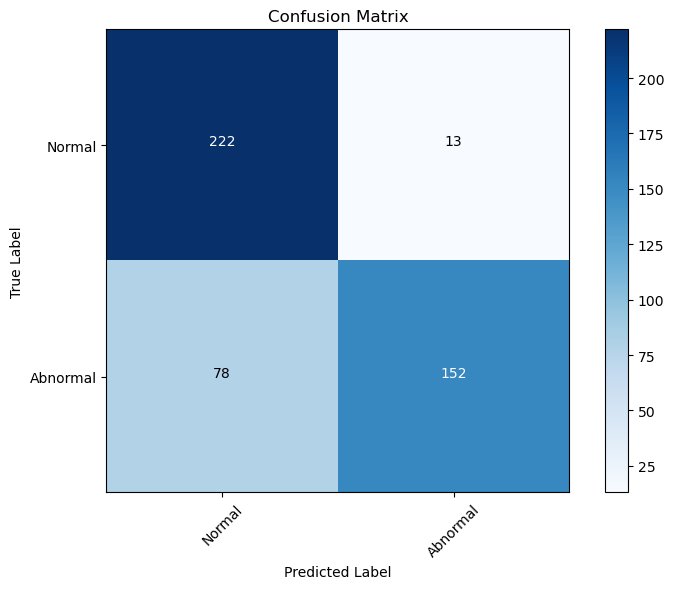

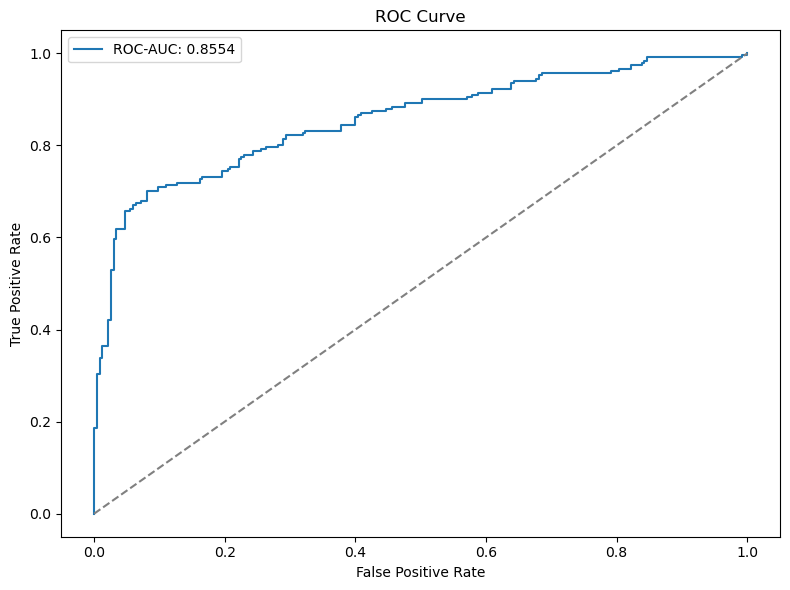

Global Metrics:
{'Accuracy': 0.8043010752688172, 'Precision': 0.9212121212121213, 'Recall': 0.6608695652173913, 'F1 Score': 0.769620253164557, 'Specificity': 0.9446808510638298, 'ROC-AUC': 0.8554486586493988, "Cohen's Kappa": 0.607376478775226, 'Kappa 95% CI Lower': 0.5493626826553286, 'Kappa 95% CI Upper': 0.6653902748951235, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83       235
         1.0       0.92      0.66      0.77       230

    accuracy                           0.80       465
   macro avg       0.83      0.80      0.80       465
weighted avg       0.83      0.80      0.80       465

Evaluating model for XR_FINGER...


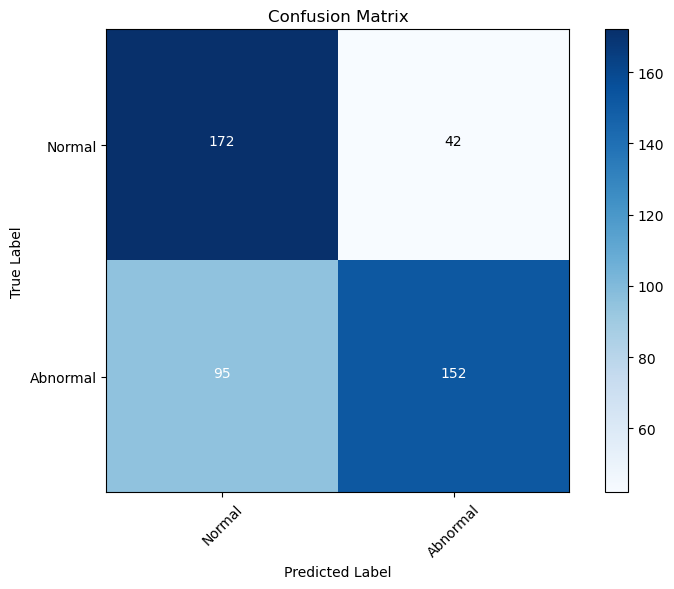

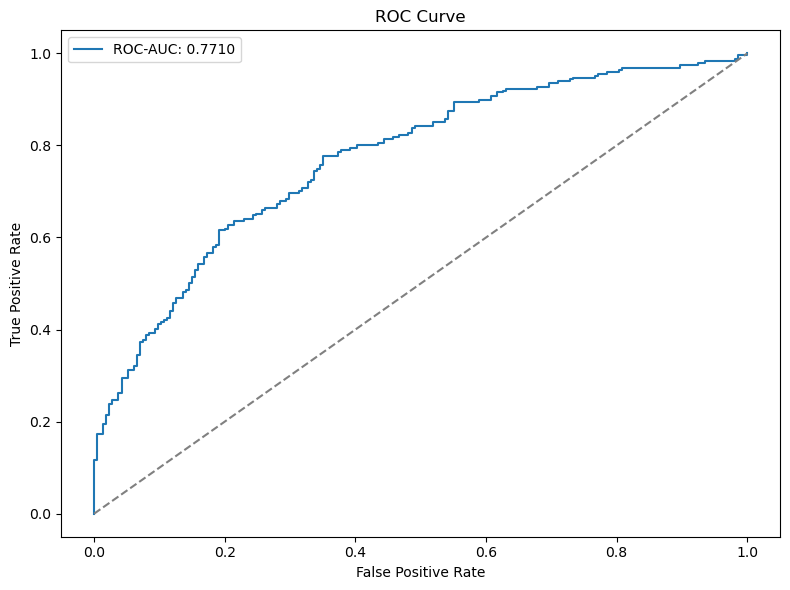

Global Metrics:
{'Accuracy': 0.702819956616052, 'Precision': 0.7835051546391752, 'Recall': 0.6153846153846154, 'F1 Score': 0.6893424036281179, 'Specificity': 0.8037383177570093, 'ROC-AUC': 0.7710280373831776, "Cohen's Kappa": 0.41230167961661934, 'Kappa 95% CI Lower': 0.35046809122284983, 'Kappa 95% CI Upper': 0.47413526801038886, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.80      0.72       214
         1.0       0.78      0.62      0.69       247

    accuracy                           0.70       461
   macro avg       0.71      0.71      0.70       461
weighted avg       0.72      0.70      0.70       461

Evaluating model for XR_FOREARM...


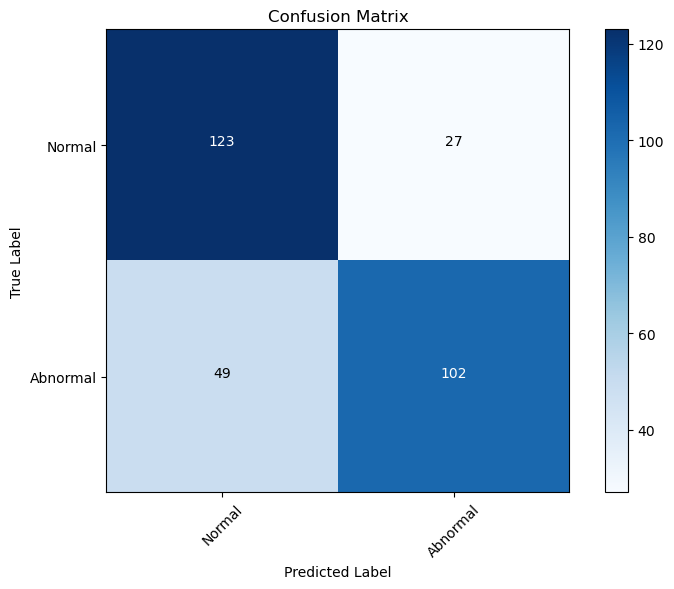

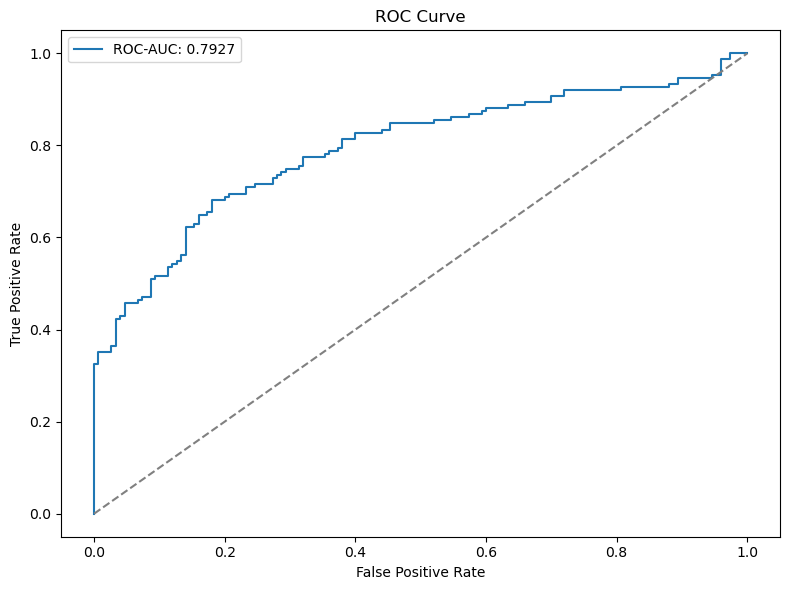

Global Metrics:
{'Accuracy': 0.7475083056478405, 'Precision': 0.7906976744186046, 'Recall': 0.6754966887417219, 'F1 Score': 0.7285714285714285, 'Specificity': 0.82, 'ROC-AUC': 0.7926710816777041, "Cohen's Kappa": 0.4952561669829223, 'Kappa 95% CI Lower': 0.4204274580800201, 'Kappa 95% CI Upper': 0.5700848758858246, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.76       150
         1.0       0.79      0.68      0.73       151

    accuracy                           0.75       301
   macro avg       0.75      0.75      0.75       301
weighted avg       0.75      0.75      0.75       301

Evaluating model for XR_HAND...


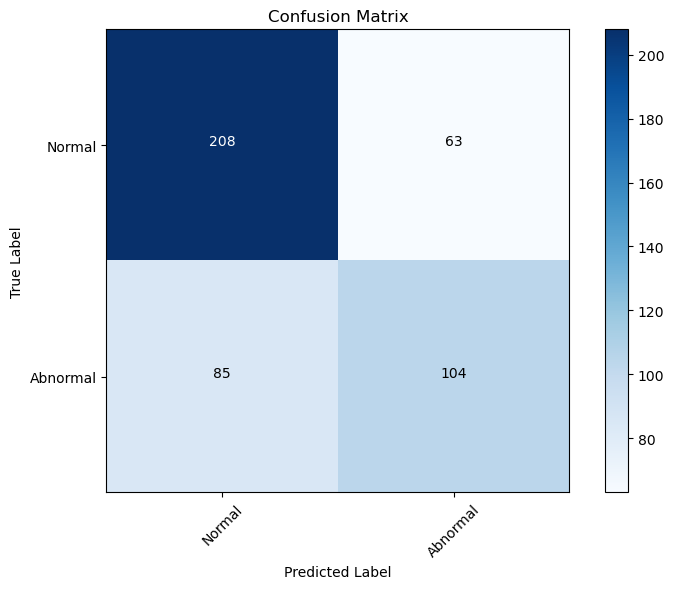

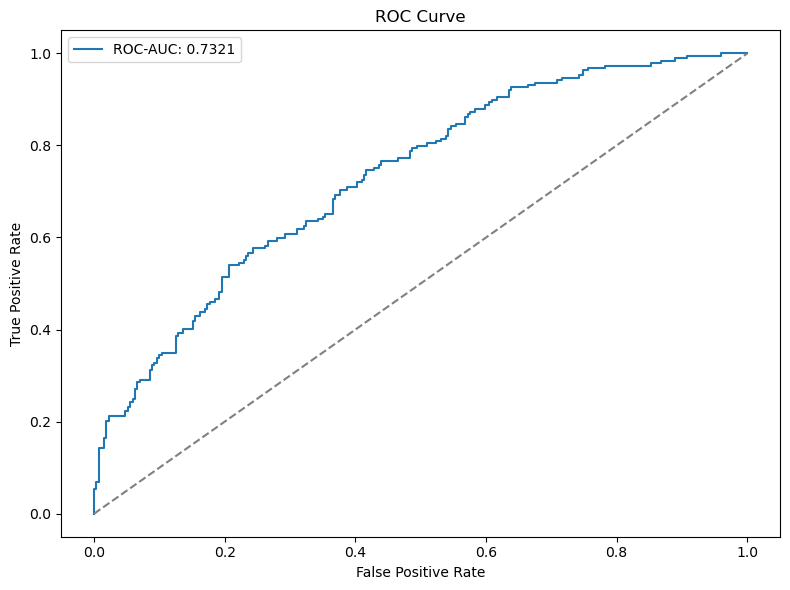

Global Metrics:
{'Accuracy': 0.6782608695652174, 'Precision': 0.6227544910179641, 'Recall': 0.5502645502645502, 'F1 Score': 0.5842696629213483, 'Specificity': 0.7675276752767528, 'ROC-AUC': 0.7320720826255882, "Cohen's Kappa": 0.3234890792376335, 'Kappa 95% CI Lower': 0.26099786352441157, 'Kappa 95% CI Upper': 0.3859802949508554, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       271
         1.0       0.62      0.55      0.58       189

    accuracy                           0.68       460
   macro avg       0.67      0.66      0.66       460
weighted avg       0.67      0.68      0.67       460

Evaluating model for XR_HUMERUS...


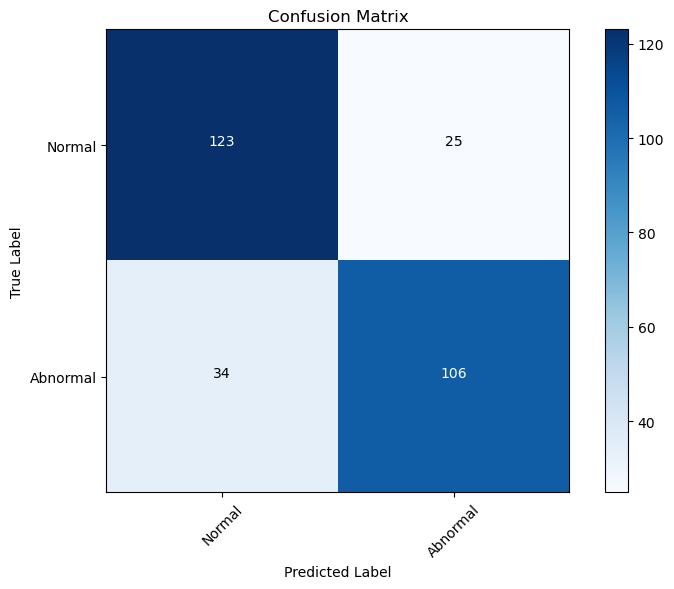

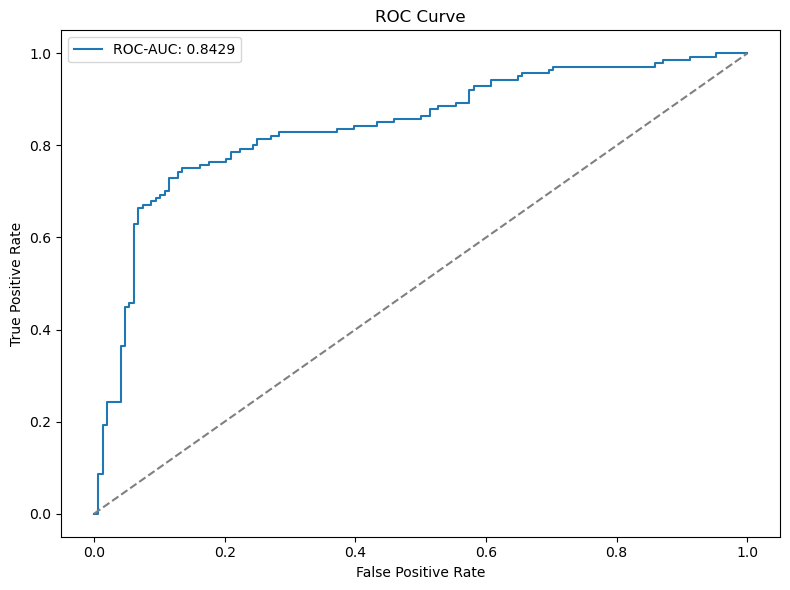

Global Metrics:
{'Accuracy': 0.7951388888888888, 'Precision': 0.8091603053435115, 'Recall': 0.7571428571428571, 'F1 Score': 0.7822878228782287, 'Specificity': 0.831081081081081, 'ROC-AUC': 0.8429054054054054, "Cohen's Kappa": 0.5892477277122413, 'Kappa 95% CI Lower': 0.5150364687212203, 'Kappa 95% CI Upper': 0.6634589867032623, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81       148
         1.0       0.81      0.76      0.78       140

    accuracy                           0.80       288
   macro avg       0.80      0.79      0.79       288
weighted avg       0.80      0.80      0.79       288

Evaluating model for XR_SHOULDER...


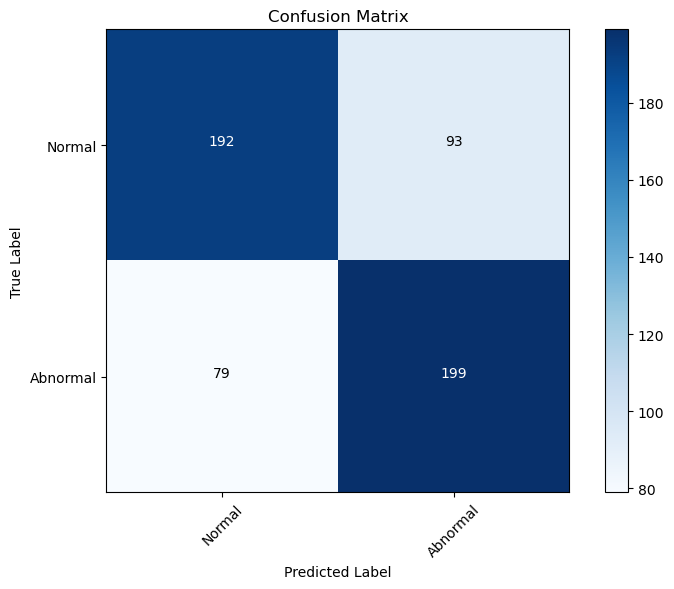

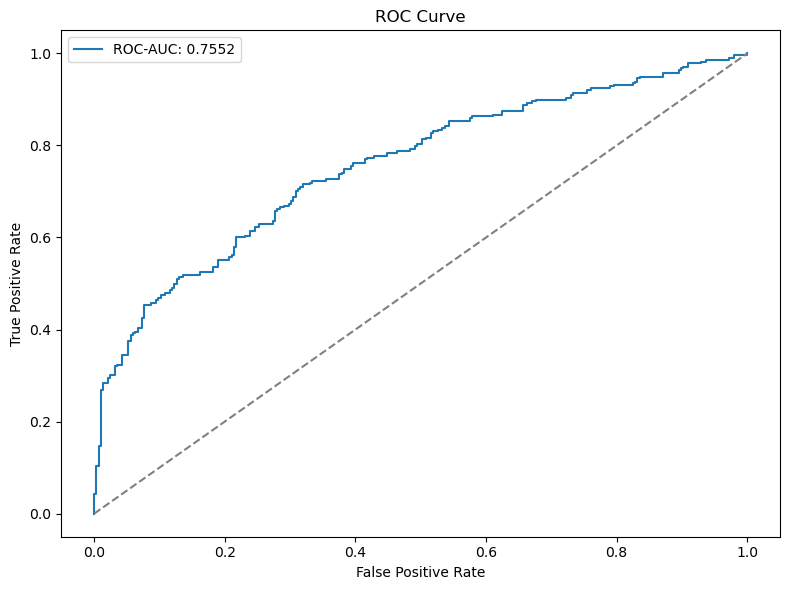

Global Metrics:
{'Accuracy': 0.69449378330373, 'Precision': 0.6815068493150684, 'Recall': 0.7158273381294964, 'F1 Score': 0.6982456140350877, 'Specificity': 0.6736842105263158, 'ROC-AUC': 0.755231604190332, "Cohen's Kappa": 0.3892708031130564, 'Kappa 95% CI Lower': 0.333114855164487, 'Kappa 95% CI Upper': 0.44542675106162577, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69       285
         1.0       0.68      0.72      0.70       278

    accuracy                           0.69       563
   macro avg       0.69      0.69      0.69       563
weighted avg       0.70      0.69      0.69       563

Evaluating model for XR_WRIST...


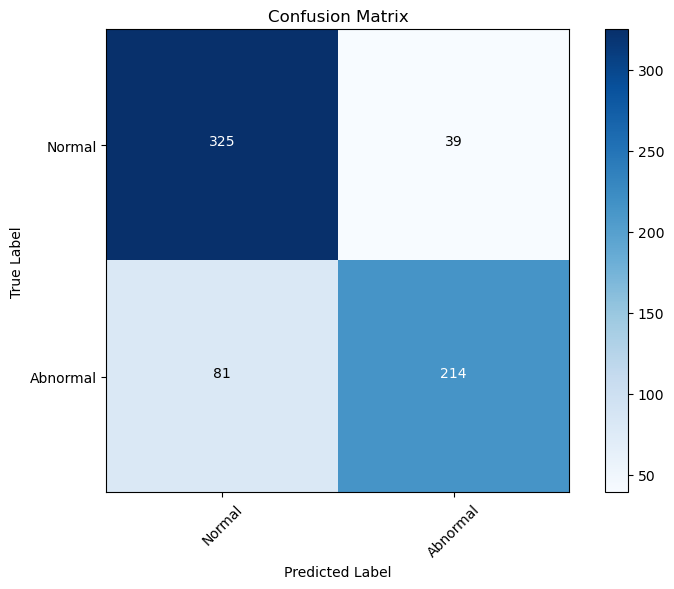

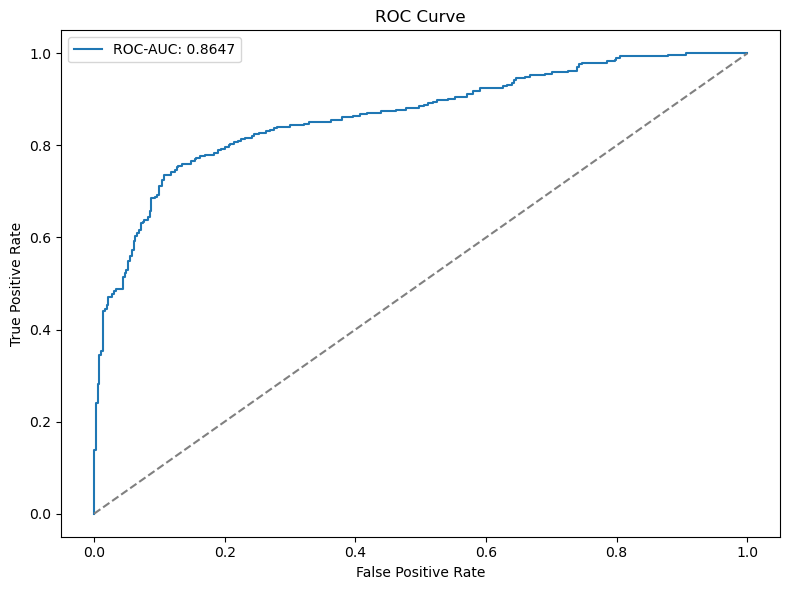

Global Metrics:
{'Accuracy': 0.8179059180576631, 'Precision': 0.8458498023715415, 'Recall': 0.7254237288135593, 'F1 Score': 0.781021897810219, 'Specificity': 0.8928571428571429, 'ROC-AUC': 0.8646675358539766, "Cohen's Kappa": 0.6267381597454946, 'Kappa 95% CI Lower': 0.578523792072095, 'Kappa 95% CI Upper': 0.6749525274188942, 'Loss': None}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       364
         1.0       0.85      0.73      0.78       295

    accuracy                           0.82       659
   macro avg       0.82      0.81      0.81       659
weighted avg       0.82      0.82      0.82       659

XR_ELBOW
   Accuracy  Precision   Recall  F1 Score  Specificity   ROC-AUC  \
0  0.804301   0.921212  0.66087   0.76962     0.944681  0.855449   

   Cohen's Kappa  Kappa 95% CI Lower  Kappa 95% CI Upper  Loss  
0       0.607376            0.549363             0.66539  None  
XR_FINGER
   Accuracy  Precisio

In [38]:
# Eval Lightweight Models

from metrics import calculate_metrics_per_body_part

ensemble_stats = []
for part, model in body_part_models.items():
    print(f"Evaluating model for {part}...")
    valid_loader_part = filter_loader(valid_loader, part)
    preds = evaluate_model(model, valid_loader_part) 
    ensemble_stats.append(part)
    ensemble_stats.append(preds)

x = 0
for i in ensemble_stats:
    if x % 2 == 0:
        print(i)
    else:
        display(i)

In [39]:
# Train the Main Model with Transfer Learning

from helpers.model_utils import get_model

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the Model
model_name = "custom_cnn1" # "densenet", "resnet", "vgg", "custom_cnn1", "body_part_cnn", "custom_cnn_attention"
main_model = get_model(model_name, device)

In [40]:
from models.custom_cnn import DepthwiseSeparableConv

def transfer_weights(source_model, target_model):
    """
    Recursively transfer weights from source_model to target_model.
    
    Args:
        source_model (nn.Module): The trained source model.
        target_model (nn.Module): The target model to which weights will be transferred.
    """
    for source_layer, target_layer in zip(source_model.children(), target_model.children()):
        if isinstance(source_layer, nn.Conv2d) and isinstance(target_layer, nn.Conv2d):
            target_layer.weight.data = source_layer.weight.data.clone()
            if target_layer.bias is not None and source_layer.bias is not None:
                target_layer.bias.data = source_layer.bias.data.clone()
        elif isinstance(source_layer, DepthwiseSeparableConv) and isinstance(target_layer, DepthwiseSeparableConv):
            target_layer.depthwise.weight.data = source_layer.depthwise.weight.data.clone()
            target_layer.pointwise.weight.data = source_layer.pointwise.weight.data.clone()
        elif isinstance(source_layer, nn.Sequential):
            transfer_weights(source_layer, target_layer)


In [41]:
# Transfer knowledge from body part models
for part, body_part_model in body_part_models.items():
    transfer_weights(body_part_model, main_model)


# 6. Define Loss, Optimizer, and Scheduler
# Compute class weights dynamically
weights = compute_class_weights(train_dataset).to(device)
# Define loss function with dynamic weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
# Define optimizer with adjusted weight decay
optimizer = optim.Adam(main_model.parameters(), lr=lr, weight_decay=weight_decay)

#base_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
base_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)
scheduler = base_scheduler
#scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epochs=5, after_scheduler=base_scheduler)


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Train the main model
main_model, train_history = train_model_kappa(main_model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=50)

C:\Users\green\AppData\Local\Temp\ipykernel_29956\72764151.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:25<00:00,  1.19it/s, accuracy=0.686, loss=0.565]


train Loss: 0.6757 Acc: 0.6857 Cohen's Kappa: 0.3341


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s, accuracy=0.794, loss=0.44]


valid Loss: 0.6394 Acc: 0.7204 Cohen's Kappa: 0.4355
Epoch 2/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:21<00:00,  1.19it/s, accuracy=0.723, loss=0.64] 


train Loss: 0.6328 Acc: 0.7234 Cohen's Kappa: 0.4134


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s, accuracy=0.803, loss=0.292]


valid Loss: 0.6331 Acc: 0.7288 Cohen's Kappa: 0.4503
Epoch 3/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:58<00:00,  1.18it/s, accuracy=0.739, loss=0.709]


train Loss: 0.6126 Acc: 0.7393 Cohen's Kappa: 0.4465


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s, accuracy=0.796, loss=0.274]


valid Loss: 0.6575 Acc: 0.7222 Cohen's Kappa: 0.4357
Epoch 4/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:17<00:00,  1.19it/s, accuracy=0.749, loss=0.563]


train Loss: 0.6003 Acc: 0.7491 Cohen's Kappa: 0.4675


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s, accuracy=0.838, loss=0.362]


valid Loss: 0.5916 Acc: 0.7601 Cohen's Kappa: 0.5176
Epoch 5/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:14<00:00,  1.19it/s, accuracy=0.754, loss=0.409]


train Loss: 0.5922 Acc: 0.7535 Cohen's Kappa: 0.4765


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s, accuracy=0.824, loss=0.314]


valid Loss: 0.5936 Acc: 0.7473 Cohen's Kappa: 0.4920
Epoch 6/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:14<00:00,  1.19it/s, accuracy=0.758, loss=0.653]


train Loss: 0.5852 Acc: 0.7583 Cohen's Kappa: 0.4873


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s, accuracy=0.836, loss=0.274]


valid Loss: 0.6108 Acc: 0.7582 Cohen's Kappa: 0.5108
Epoch 7/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:42<00:00,  1.20it/s, accuracy=0.762, loss=0.622]


train Loss: 0.5797 Acc: 0.7621 Cohen's Kappa: 0.4952


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s, accuracy=0.837, loss=0.329]


valid Loss: 0.5899 Acc: 0.7591 Cohen's Kappa: 0.5123
Epoch 8/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:36<00:00,  1.21it/s, accuracy=0.765, loss=0.464]


train Loss: 0.5746 Acc: 0.7650 Cohen's Kappa: 0.5020


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s, accuracy=0.845, loss=0.291]


valid Loss: 0.5893 Acc: 0.7667 Cohen's Kappa: 0.5281
Epoch 9/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:34<00:00,  1.21it/s, accuracy=0.767, loss=0.48] 


train Loss: 0.5697 Acc: 0.7669 Cohen's Kappa: 0.5060


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s, accuracy=0.832, loss=0.397]


valid Loss: 0.5848 Acc: 0.7548 Cohen's Kappa: 0.5061
Epoch 10/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:49<00:00,  1.20it/s, accuracy=0.769, loss=0.57] 


train Loss: 0.5661 Acc: 0.7693 Cohen's Kappa: 0.5111


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s, accuracy=0.811, loss=0.27]


valid Loss: 0.6597 Acc: 0.7357 Cohen's Kappa: 0.4612
Epoch 11/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:20<00:00,  1.23it/s, accuracy=0.772, loss=0.717]


train Loss: 0.5623 Acc: 0.7719 Cohen's Kappa: 0.5168


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s, accuracy=0.843, loss=0.271]


valid Loss: 0.5904 Acc: 0.7645 Cohen's Kappa: 0.5217
Epoch 12/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:40<00:00,  1.22it/s, accuracy=0.773, loss=0.611]


train Loss: 0.5607 Acc: 0.7733 Cohen's Kappa: 0.5195


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s, accuracy=0.855, loss=0.32]


valid Loss: 0.5707 Acc: 0.7757 Cohen's Kappa: 0.5471
Epoch 13/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:22<00:00,  1.23it/s, accuracy=0.774, loss=0.515]


train Loss: 0.5574 Acc: 0.7741 Cohen's Kappa: 0.5217


valid Progress: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s, accuracy=0.817, loss=0.496]


valid Loss: 0.5663 Acc: 0.7413 Cohen's Kappa: 0.4836
Epoch 14/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:15<00:00,  1.23it/s, accuracy=0.776, loss=0.519]


train Loss: 0.5546 Acc: 0.7758 Cohen's Kappa: 0.5257


valid Progress: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, accuracy=0.84, loss=0.281]


valid Loss: 0.6524 Acc: 0.7623 Cohen's Kappa: 0.5190
Epoch 15/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:29<00:00,  1.23it/s, accuracy=0.776, loss=0.756]


train Loss: 0.5558 Acc: 0.7757 Cohen's Kappa: 0.5252


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s, accuracy=0.823, loss=0.241]


valid Loss: 0.6435 Acc: 0.7470 Cohen's Kappa: 0.4848
Epoch 16/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:34<00:00,  1.23it/s, accuracy=0.777, loss=0.723]


train Loss: 0.5531 Acc: 0.7774 Cohen's Kappa: 0.5290


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s, accuracy=0.844, loss=0.37]


valid Loss: 0.5742 Acc: 0.7654 Cohen's Kappa: 0.5273
Epoch 17/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:24<00:00,  1.23it/s, accuracy=0.778, loss=0.479]


train Loss: 0.5510 Acc: 0.7784 Cohen's Kappa: 0.5308


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s, accuracy=0.865, loss=0.365]


valid Loss: 0.5514 Acc: 0.7845 Cohen's Kappa: 0.5654
Epoch 18/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:17<00:00,  1.23it/s, accuracy=0.78, loss=0.595] 


train Loss: 0.5487 Acc: 0.7795 Cohen's Kappa: 0.5335


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s, accuracy=0.859, loss=0.33] 


valid Loss: 0.5631 Acc: 0.7789 Cohen's Kappa: 0.5539
Epoch 19/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:26<00:00,  1.23it/s, accuracy=0.78, loss=0.615] 


train Loss: 0.5489 Acc: 0.7801 Cohen's Kappa: 0.5345


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s, accuracy=0.852, loss=0.358]


valid Loss: 0.5537 Acc: 0.7732 Cohen's Kappa: 0.5432
Epoch 20/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:39<00:00,  1.19it/s, accuracy=0.78, loss=0.667] 


train Loss: 0.5471 Acc: 0.7802 Cohen's Kappa: 0.5350


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s, accuracy=0.853, loss=0.309]


valid Loss: 0.5638 Acc: 0.7739 Cohen's Kappa: 0.5440
Epoch 21/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:06<00:00,  1.22it/s, accuracy=0.78, loss=0.433] 


train Loss: 0.5467 Acc: 0.7801 Cohen's Kappa: 0.5349


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s, accuracy=0.856, loss=0.261]


valid Loss: 0.5725 Acc: 0.7760 Cohen's Kappa: 0.5470
Epoch 22/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:37<00:00,  1.22it/s, accuracy=0.782, loss=0.444]


train Loss: 0.5458 Acc: 0.7815 Cohen's Kappa: 0.5377


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s, accuracy=0.852, loss=0.327]


valid Loss: 0.5527 Acc: 0.7726 Cohen's Kappa: 0.5417
Epoch 23/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:32<00:00,  1.23it/s, accuracy=0.782, loss=0.381]


train Loss: 0.5436 Acc: 0.7820 Cohen's Kappa: 0.5389


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s, accuracy=0.855, loss=0.253]


valid Loss: 0.5768 Acc: 0.7757 Cohen's Kappa: 0.5461
Epoch 24/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:42<00:00,  1.22it/s, accuracy=0.794, loss=0.356]


train Loss: 0.5225 Acc: 0.7941 Cohen's Kappa: 0.5650


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s, accuracy=0.87, loss=0.253]


valid Loss: 0.5676 Acc: 0.7892 Cohen's Kappa: 0.5732
Epoch 25/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:49<00:00,  1.22it/s, accuracy=0.795, loss=0.572]


train Loss: 0.5199 Acc: 0.7947 Cohen's Kappa: 0.5663


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s, accuracy=0.866, loss=0.253]


valid Loss: 0.5416 Acc: 0.7857 Cohen's Kappa: 0.5690
Epoch 26/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:32<00:00,  1.23it/s, accuracy=0.796, loss=0.688]


train Loss: 0.5182 Acc: 0.7960 Cohen's Kappa: 0.5693


valid Progress: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s, accuracy=0.873, loss=0.425]


valid Loss: 0.5318 Acc: 0.7917 Cohen's Kappa: 0.5809
Epoch 27/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:49<00:00,  1.22it/s, accuracy=0.797, loss=0.585]


train Loss: 0.5154 Acc: 0.7971 Cohen's Kappa: 0.5719


valid Progress: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s, accuracy=0.873, loss=0.269]


valid Loss: 0.5532 Acc: 0.7917 Cohen's Kappa: 0.5797
Epoch 28/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:49<00:00,  1.22it/s, accuracy=0.797, loss=0.4]  


train Loss: 0.5142 Acc: 0.7968 Cohen's Kappa: 0.5713


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s, accuracy=0.879, loss=0.269]


valid Loss: 0.5454 Acc: 0.7970 Cohen's Kappa: 0.5894
Epoch 29/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:56<00:00,  1.22it/s, accuracy=0.797, loss=0.685]


train Loss: 0.5122 Acc: 0.7968 Cohen's Kappa: 0.5712


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s, accuracy=0.876, loss=0.326]


valid Loss: 0.5296 Acc: 0.7948 Cohen's Kappa: 0.5878
Epoch 30/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:27<00:00,  1.23it/s, accuracy=0.798, loss=0.502]


train Loss: 0.5110 Acc: 0.7983 Cohen's Kappa: 0.5746


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s, accuracy=0.855, loss=0.203]


valid Loss: 0.6028 Acc: 0.7754 Cohen's Kappa: 0.5437
Epoch 31/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:17<00:00,  1.23it/s, accuracy=0.799, loss=0.657]


train Loss: 0.5099 Acc: 0.7993 Cohen's Kappa: 0.5766


valid Progress: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s, accuracy=0.87, loss=0.372] 


valid Loss: 0.5382 Acc: 0.7889 Cohen's Kappa: 0.5757
Epoch 32/50
----------


train Progress: 100%|██████████| 4601/4601 [1:01:23<00:00,  1.25it/s, accuracy=0.799, loss=0.549]


train Loss: 0.5090 Acc: 0.7991 Cohen's Kappa: 0.5764


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s, accuracy=0.864, loss=0.262]


valid Loss: 0.5598 Acc: 0.7835 Cohen's Kappa: 0.5632
Epoch 33/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:24<00:00,  1.23it/s, accuracy=0.8, loss=0.443]  


train Loss: 0.5087 Acc: 0.7996 Cohen's Kappa: 0.5775


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s, accuracy=0.863, loss=0.525]


valid Loss: 0.5588 Acc: 0.7826 Cohen's Kappa: 0.5631
Epoch 34/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:18<00:00,  1.23it/s, accuracy=0.802, loss=0.451]


train Loss: 0.5066 Acc: 0.8019 Cohen's Kappa: 0.5824


valid Progress: 100%|██████████| 100/100 [00:47<00:00,  2.13it/s, accuracy=0.857, loss=0.375]


valid Loss: 0.5552 Acc: 0.7776 Cohen's Kappa: 0.5544
Epoch 35/50
----------


train Progress: 100%|██████████| 4601/4601 [1:01:57<00:00,  1.24it/s, accuracy=0.8, loss=0.537] 


train Loss: 0.5068 Acc: 0.8004 Cohen's Kappa: 0.5792


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s, accuracy=0.867, loss=0.206]


valid Loss: 0.5663 Acc: 0.7867 Cohen's Kappa: 0.5687
Epoch 36/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:09<00:00,  1.23it/s, accuracy=0.808, loss=0.549]


train Loss: 0.4908 Acc: 0.8081 Cohen's Kappa: 0.5956


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s, accuracy=0.871, loss=0.306]


valid Loss: 0.5450 Acc: 0.7904 Cohen's Kappa: 0.5775
Epoch 37/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:05<00:00,  1.24it/s, accuracy=0.81, loss=0.427]


train Loss: 0.4870 Acc: 0.8102 Cohen's Kappa: 0.6005


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s, accuracy=0.866, loss=0.469]


valid Loss: 0.5361 Acc: 0.7854 Cohen's Kappa: 0.5696
Epoch 38/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:24<00:00,  1.23it/s, accuracy=0.812, loss=0.496]


train Loss: 0.4832 Acc: 0.8117 Cohen's Kappa: 0.6038


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s, accuracy=0.874, loss=0.431]


valid Loss: 0.5318 Acc: 0.7929 Cohen's Kappa: 0.5841
Epoch 39/50
----------


train Progress: 100%|██████████| 4601/4601 [1:01:19<00:00,  1.25it/s, accuracy=0.813, loss=0.26] 


train Loss: 0.4824 Acc: 0.8127 Cohen's Kappa: 0.6059


valid Progress: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s, accuracy=0.862, loss=0.209]


valid Loss: 0.6131 Acc: 0.7823 Cohen's Kappa: 0.5586
Epoch 40/50
----------


train Progress: 100%|██████████| 4601/4601 [58:50<00:00,  1.30it/s, accuracy=0.812, loss=0.555] 


train Loss: 0.4834 Acc: 0.8119 Cohen's Kappa: 0.6042


valid Progress: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s, accuracy=0.872, loss=0.317]


valid Loss: 0.5434 Acc: 0.7911 Cohen's Kappa: 0.5791
Epoch 41/50
----------


train Progress: 100%|██████████| 4601/4601 [57:37<00:00,  1.33it/s, accuracy=0.813, loss=0.517] 


train Loss: 0.4805 Acc: 0.8133 Cohen's Kappa: 0.6073


valid Progress: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s, accuracy=0.876, loss=0.352]


valid Loss: 0.5417 Acc: 0.7945 Cohen's Kappa: 0.5860
Epoch 42/50
----------


train Progress: 100%|██████████| 4601/4601 [1:00:00<00:00,  1.28it/s, accuracy=0.817, loss=0.443]


train Loss: 0.4719 Acc: 0.8173 Cohen's Kappa: 0.6156


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s, accuracy=0.874, loss=0.374]


valid Loss: 0.5259 Acc: 0.7929 Cohen's Kappa: 0.5841
Epoch 43/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:30<00:00,  1.23it/s, accuracy=0.819, loss=0.646]


train Loss: 0.4687 Acc: 0.8187 Cohen's Kappa: 0.6189


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s, accuracy=0.878, loss=0.372]


valid Loss: 0.5484 Acc: 0.7961 Cohen's Kappa: 0.5891
Epoch 44/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:15<00:00,  1.23it/s, accuracy=0.819, loss=0.613]


train Loss: 0.4671 Acc: 0.8193 Cohen's Kappa: 0.6202


valid Progress: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s, accuracy=0.872, loss=0.361]


valid Loss: 0.5390 Acc: 0.7914 Cohen's Kappa: 0.5802
Epoch 45/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:37<00:00,  1.22it/s, accuracy=0.82, loss=0.495]


train Loss: 0.4652 Acc: 0.8197 Cohen's Kappa: 0.6211


valid Progress: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s, accuracy=0.877, loss=0.364]


valid Loss: 0.5443 Acc: 0.7957 Cohen's Kappa: 0.5889
Epoch 46/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:34<00:00,  1.23it/s, accuracy=0.82, loss=0.372] 


train Loss: 0.4649 Acc: 0.8196 Cohen's Kappa: 0.6208


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s, accuracy=0.873, loss=0.321]


valid Loss: 0.5464 Acc: 0.7923 Cohen's Kappa: 0.5822
Epoch 47/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:32<00:00,  1.23it/s, accuracy=0.821, loss=0.485]


train Loss: 0.4637 Acc: 0.8211 Cohen's Kappa: 0.6242


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s, accuracy=0.866, loss=0.403]


valid Loss: 0.5371 Acc: 0.7851 Cohen's Kappa: 0.5694
Epoch 48/50
----------


train Progress: 100%|██████████| 4601/4601 [1:02:24<00:00,  1.23it/s, accuracy=0.822, loss=0.368]


train Loss: 0.4623 Acc: 0.8221 Cohen's Kappa: 0.6262


valid Progress: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s, accuracy=0.878, loss=0.296]


valid Loss: 0.5569 Acc: 0.7967 Cohen's Kappa: 0.5898
Epoch 49/50
----------


train Progress: 100%|██████████| 4601/4601 [1:04:38<00:00,  1.19it/s, accuracy=0.824, loss=0.524]


train Loss: 0.4575 Acc: 0.8240 Cohen's Kappa: 0.6302


valid Progress: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s, accuracy=0.878, loss=0.313]


valid Loss: 0.5444 Acc: 0.7961 Cohen's Kappa: 0.5894
Epoch 50/50
----------


train Progress: 100%|██████████| 4601/4601 [1:03:01<00:00,  1.22it/s, accuracy=0.824, loss=0.515]


train Loss: 0.4571 Acc: 0.8243 Cohen's Kappa: 0.6309


valid Progress: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s, accuracy=0.878, loss=0.327]


valid Loss: 0.5562 Acc: 0.7967 Cohen's Kappa: 0.5904
Best Validation Cohen's Kappa: 0.5904


In [ ]:
#print(f"Computed Class Weights:", {weights})

Computed Class Weights: {tensor([0.8126, 1.2997], device='cuda:0')}


In [43]:
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, classification_report,
    precision_recall_fscore_support, cohen_kappa_score, roc_curve
)

In [44]:
model_name = "CustomCNN_ensemble_w_CustomCNN1_cg_1_epoch_50.pth"
# Save the model
#torch.save(model.state_dict(), 'model_name')
# Load the model
if device == 'cuda':
    main_model.load_state_dict(torch.load(model_name))
elif device == 'mps':
    main_model.load_state_dict(torch.load(model_name, map_location=torch.device('mps')))
else:
    main_model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
# Evaluate on validation set
main_model.eval()

C:\Users\green\AppData\Local\Temp\ipykernel_29956\284146156.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  main_model.load_state_dict(torch.load(model_name, map_locati

CustomCNN1(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3)

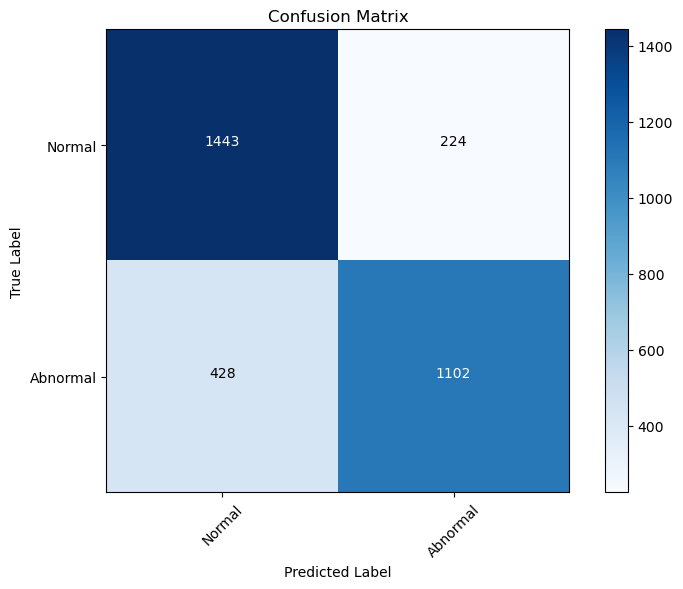

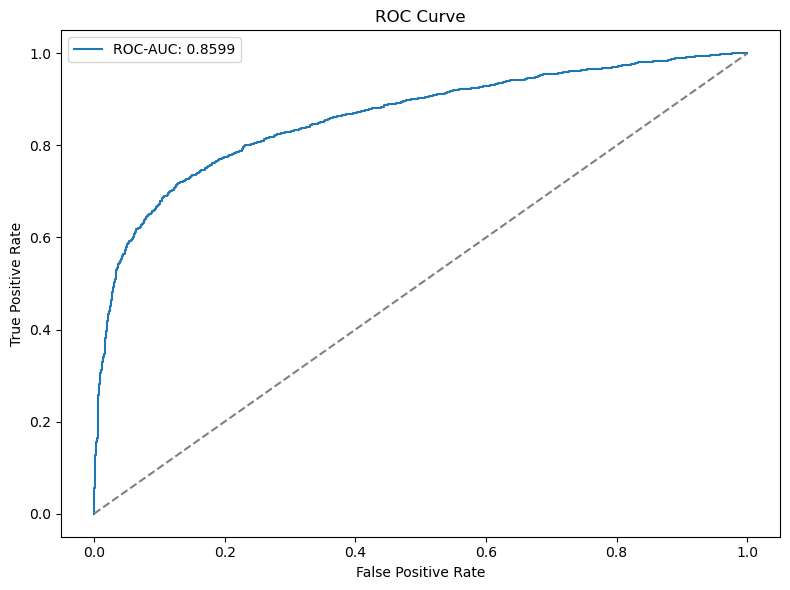

Global Metrics:
{'Accuracy': 0.7960588051298092, 'Precision': 0.8310708898944194, 'Recall': 0.7202614379084967, 'F1 Score': 0.7717086834733894, 'Specificity': 0.865626874625075, 'ROC-AUC': 0.8599362480445087, "Cohen's Kappa": 0.5891160227964436, 'Kappa 95% CI Lower': 0.5668571936110786, 'Kappa 95% CI Upper': 0.6113748519818086, 'Loss': 0.5561090470628138}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82      1667
         1.0       0.83      0.72      0.77      1530

    accuracy                           0.80      3197
   macro avg       0.80      0.79      0.79      3197
weighted avg       0.80      0.80      0.79      3197

Metrics per body part:
             Accuracy  Precision    Recall  F1 Score  Specificity   ROC-AUC  \
XR_WRIST     0.857360   0.876404  0.793220  0.832740     0.909341  0.912414   
XR_FOREARM   0.784053   0.921569  0.622517  0.743083     0.946667  0.842119   
XR_HAND      0.767391   0.815385

Accuracy  Precision    Recall  F1 Score  Specificity   ROC-AUC  \
0  0.796059   0.831071  0.720261  0.771709     0.865627  0.859936   

   Cohen's Kappa  Kappa 95% CI Lower  Kappa 95% CI Upper      Loss  
0       0.589116            0.566857            0.611375  0.556109

In [45]:
# Evaluate on validation set
metrics = evaluate_model(main_model, valid_loader, dataset=valid_dataset, criterion=criterion)
display(metrics)

### Combine Main Model and Body Part Models


Global Ensemble Metrics:
{'Accuracy': 0.7916796997184861, 'Precision': 0.8153284671532847, 'Recall': 0.7300653594771241, 'F1 Score': 0.7703448275862068, 'Specificity': 0.8482303539292142, 'ROC-AUC': 0.8542844372302011, "Cohen's Kappa": 0.5807914788053001}

Body Part Metrics:
XR_ELBOW: {'Accuracy': 0.8193548387096774, 'Precision': 0.8686868686868687, 'Recall': 0.7478260869565218, 'F1 Score': 0.8037383177570094, 'Specificity': 0.8893617021276595, 'ROC-AUC': 0.8891581868640148, "Cohen's Kappa": 0.6381322957198443}
XR_FINGER: {'Accuracy': 0.7917570498915402, 'Precision': 0.8511627906976744, 'Recall': 0.7408906882591093, 'F1 Score': 0.7922077922077922, 'Specificity': 0.8504672897196262, 'ROC-AUC': 0.8486889401793485, "Cohen's Kappa": 0.5855093095568127}
XR_FOREARM: {'Accuracy': 0.7541528239202658, 'Precision': 0.9139784946236559, 'Recall': 0.5629139072847682, 'F1 Score': 0.6967213114754098, 'Specificity': 0.9466666666666667, 'ROC-AUC': 0.8539955849889626, "Cohen's Kappa": 0.508928965121919

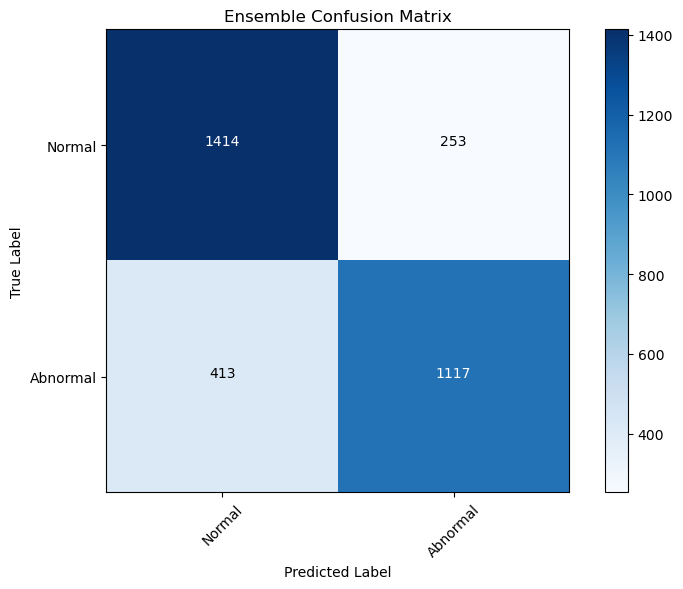

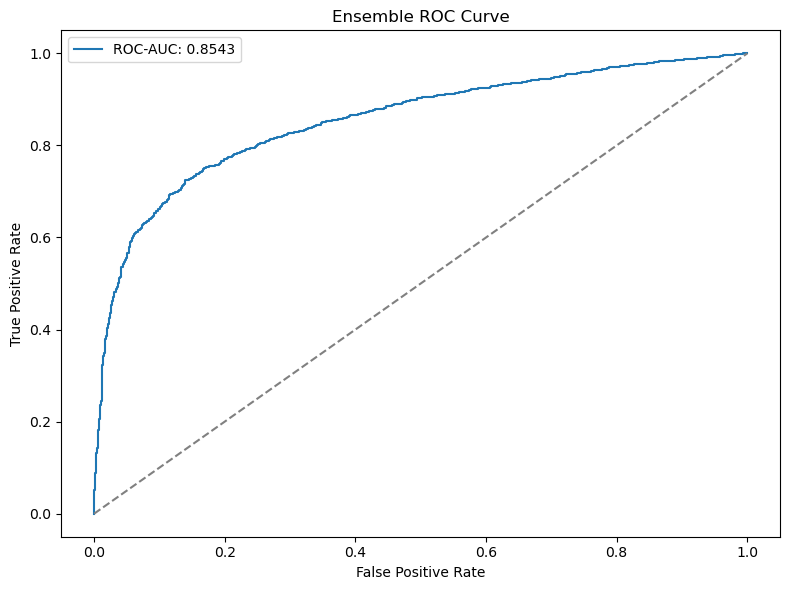

{'Accuracy': 0.7916796997184861, 'Precision': 0.8153284671532847, 'Recall': 0.7300653594771241, 'F1 Score': 0.7703448275862068, 'Specificity': 0.8482303539292142, 'ROC-AUC': 0.8542844372302011, "Cohen's Kappa": 0.5807914788053001}
{'XR_ELBOW': {'Accuracy': 0.8193548387096774, 'Precision': 0.8686868686868687, 'Recall': 0.7478260869565218, 'F1 Score': 0.8037383177570094, 'Specificity': 0.8893617021276595, 'ROC-AUC': 0.8891581868640148, "Cohen's Kappa": 0.6381322957198443}, 'XR_FINGER': {'Accuracy': 0.7917570498915402, 'Precision': 0.8511627906976744, 'Recall': 0.7408906882591093, 'F1 Score': 0.7922077922077922, 'Specificity': 0.8504672897196262, 'ROC-AUC': 0.8486889401793485, "Cohen's Kappa": 0.5855093095568127}, 'XR_FOREARM': {'Accuracy': 0.7541528239202658, 'Precision': 0.9139784946236559, 'Recall': 0.5629139072847682, 'F1 Score': 0.6967213114754098, 'Specificity': 0.9466666666666667, 'ROC-AUC': 0.8539955849889626, "Cohen's Kappa": 0.508928965121919}, 'XR_HAND': {'Accuracy': 0.78695652

In [46]:
from metrics import evaluate_ensemble

ensemble_metrics, body_part_metrics, kappa_ci = evaluate_ensemble(
    main_model=main_model,
    body_part_models=body_part_models,
    loader=valid_loader,
    dataset=valid_loader.dataset,
    device=device,
    class_names=["Normal", "Abnormal"]
)

print(ensemble_metrics)
print(body_part_metrics)
print(kappa_ci)

## Visualizations

In [47]:
from visualizer import find_last_conv_layer, run_gradcam, GradCAM, run_gradcam_filtered, run_gradcam_for_path_person_or_bodypart

In [48]:
model = main_model
layer_name, target_layer = find_last_conv_layer(model)
print(layer_name)
print(target_layer)


final_conv.6
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)


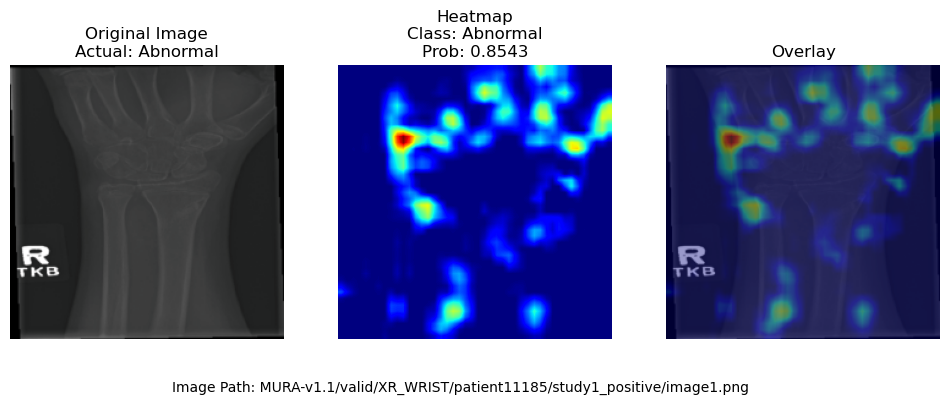

In [49]:
#Generates minimum n images or batch size images from first batch
run_gradcam(model, valid_loader, target_layer, class_names=["Normal", "Abnormal"], device=device, num_images=2)

In [50]:
body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HAND", "XR_HUMERUS", "XR_SHOULDER", "XR_WRIST"]

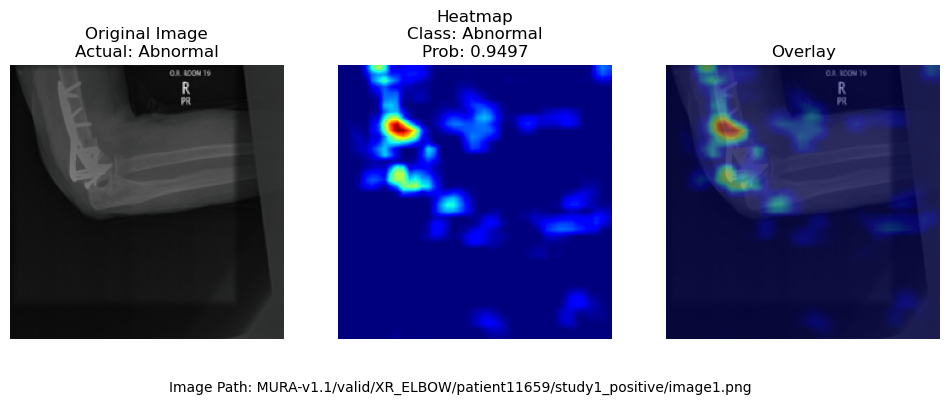

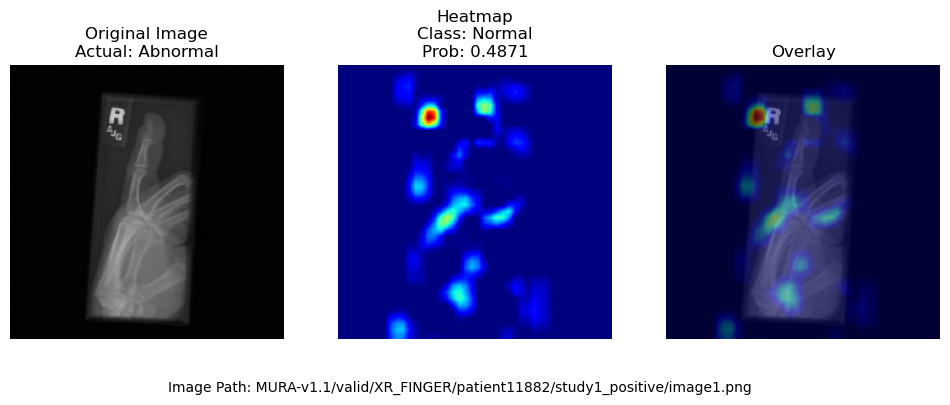

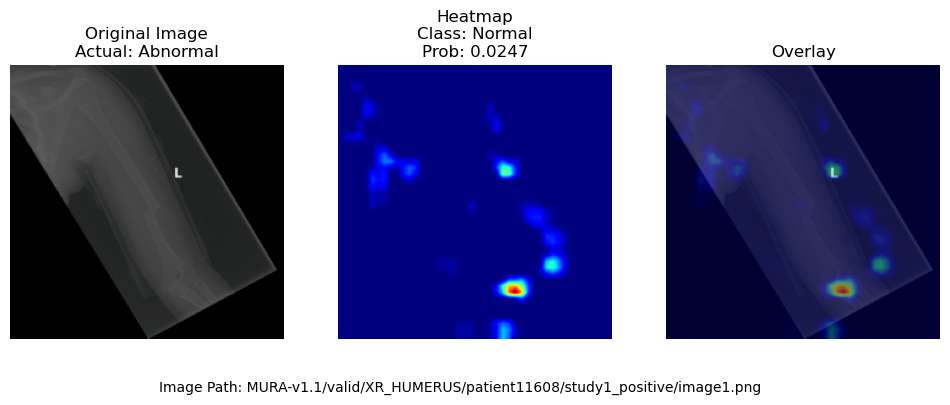

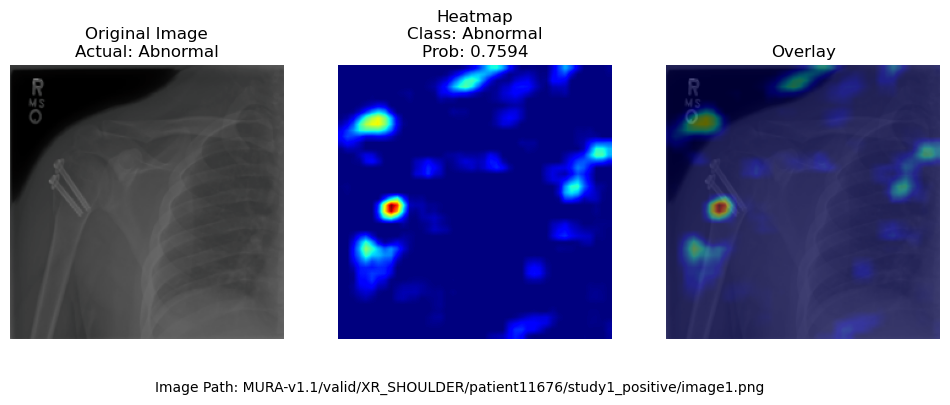

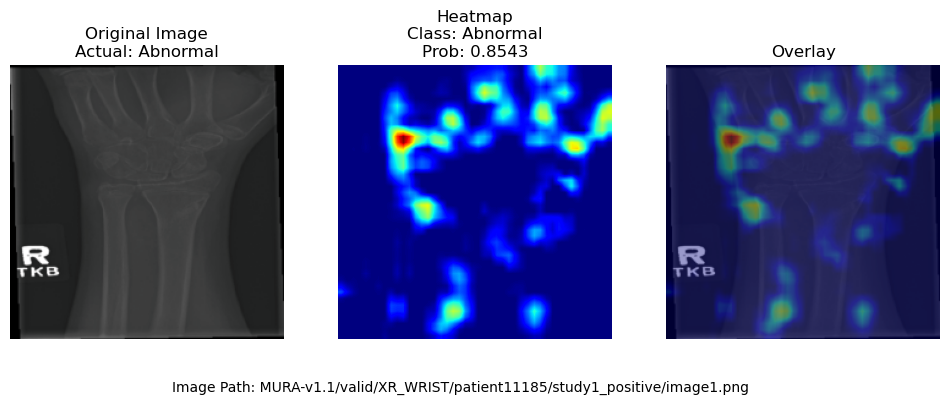

In [51]:
#Get 3 images from each bodypart
for x in body_parts:
    run_gradcam_filtered(
        model=model,
        dataloader=valid_loader,
        target_layer=target_layer,
        class_names=["Normal", "Abnormal"],
        body_part=x,
        n=1,
        device=device
    )

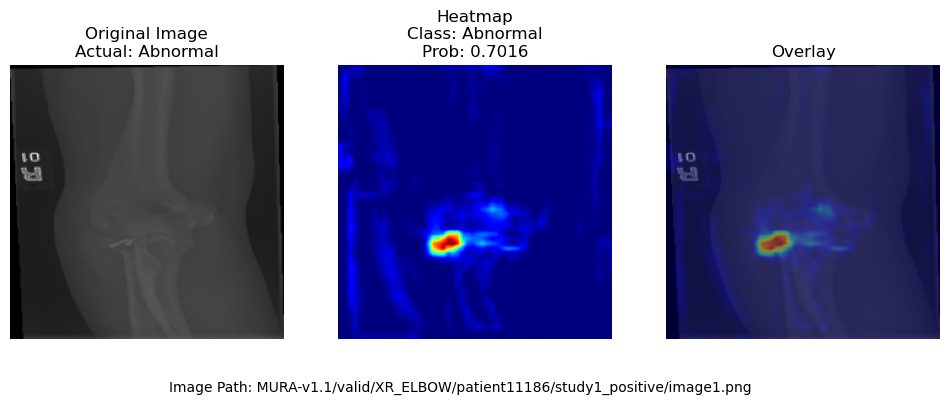

In [231]:
#Specific Image Path, must have these slashes /
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    image_path="MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image1.png",
    device=device
)

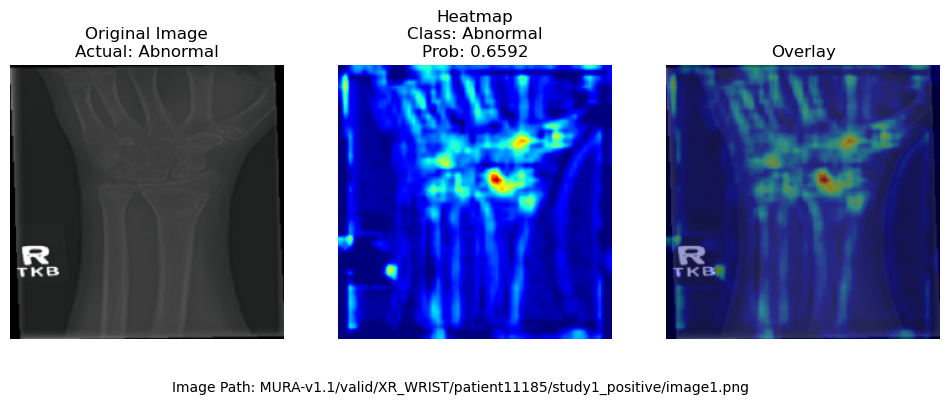

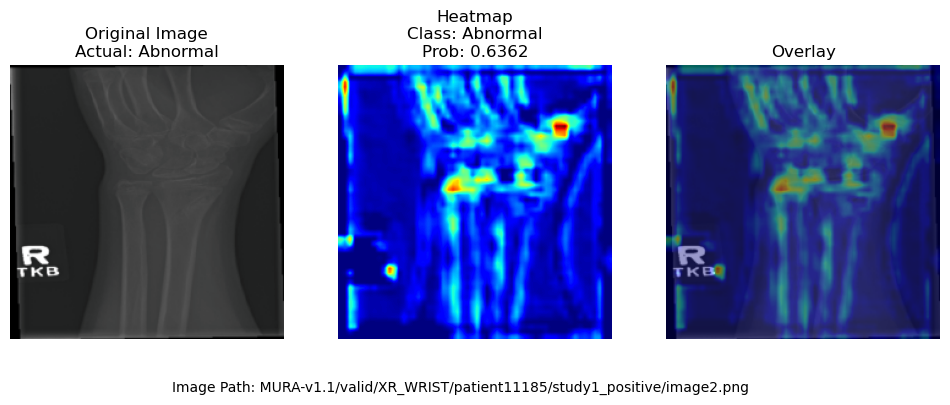

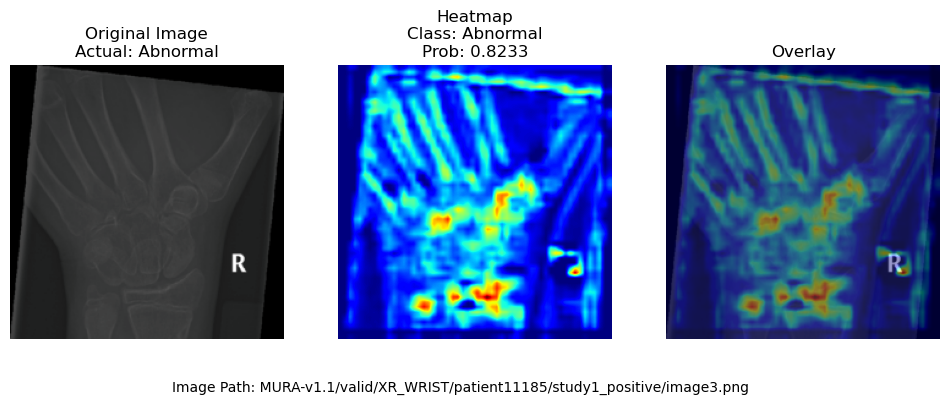

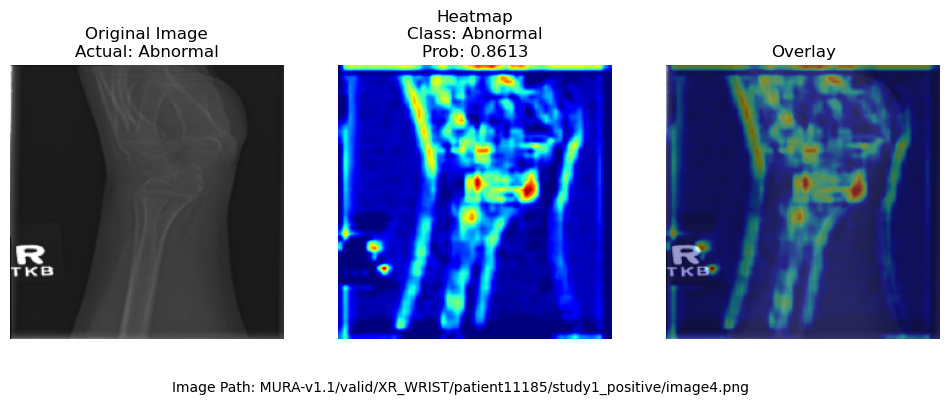

In [232]:
#Specific Body Part on a Person
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    person_id="patient11185",
    body_part="XR_WRIST",
    device=device
)


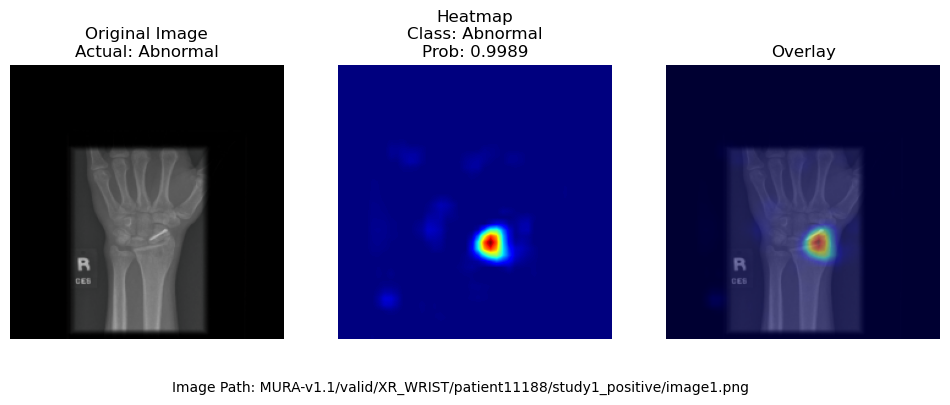

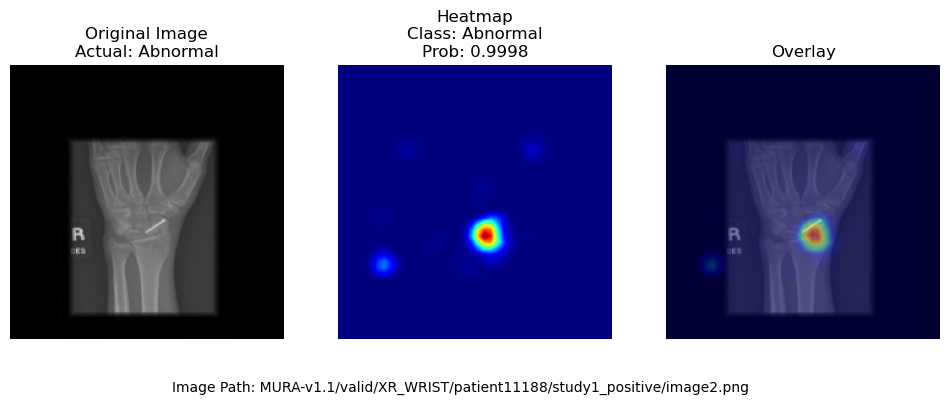

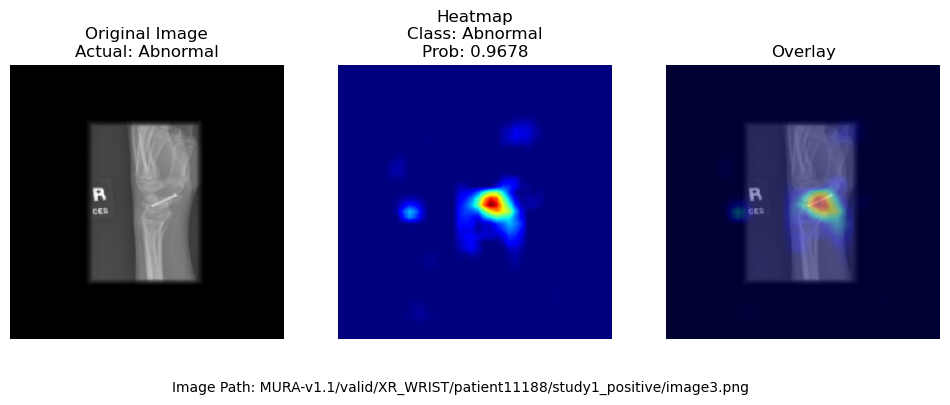

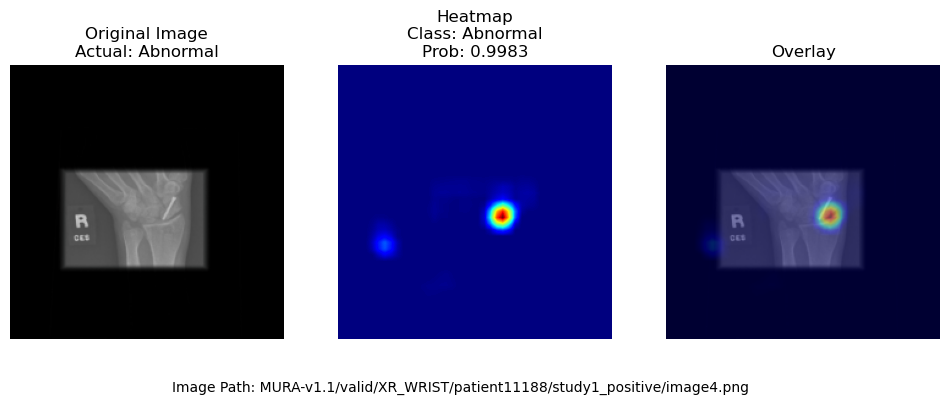

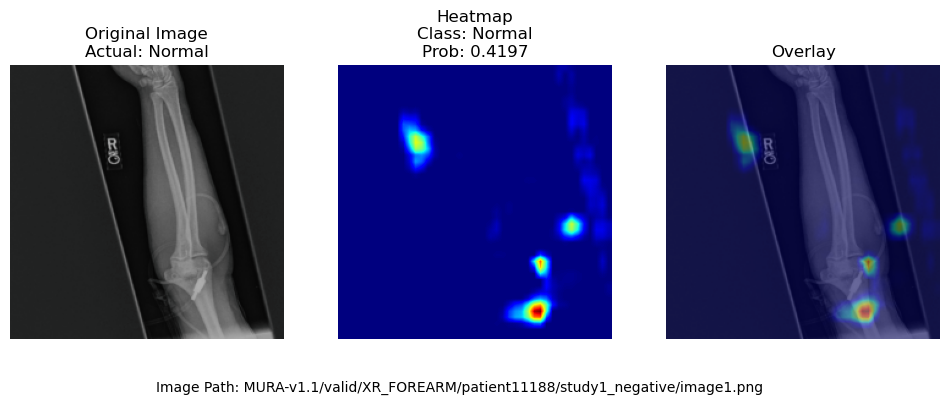

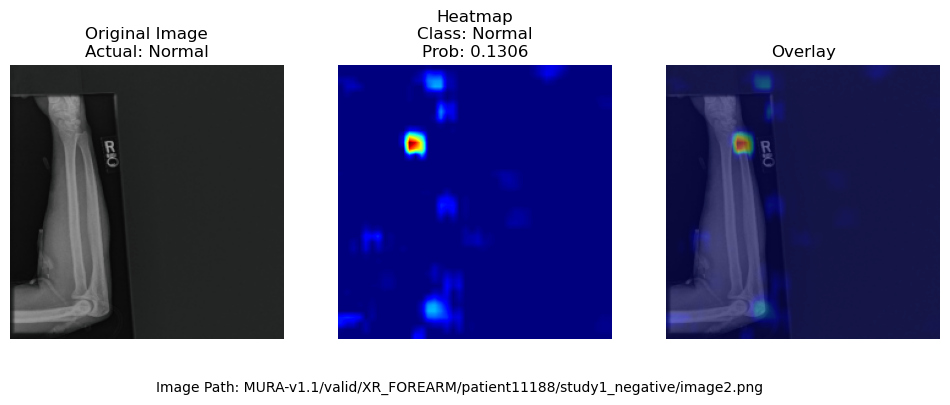

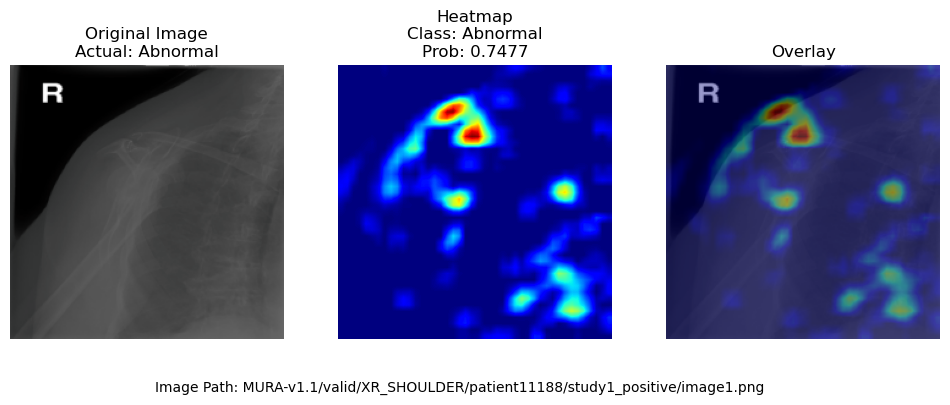

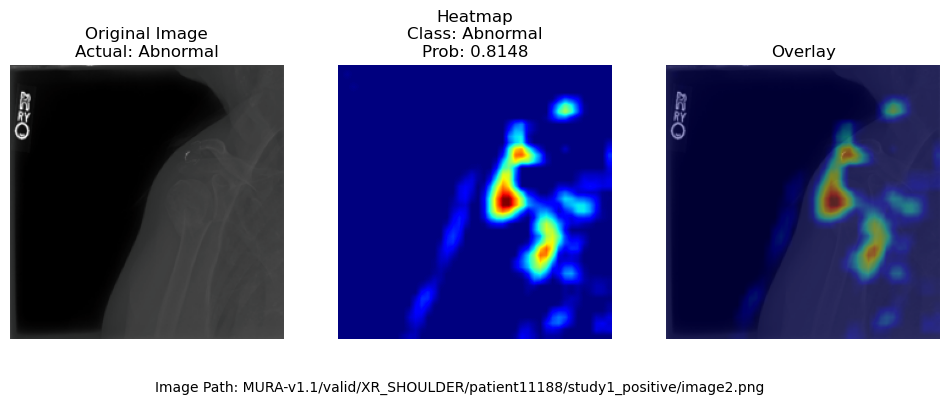

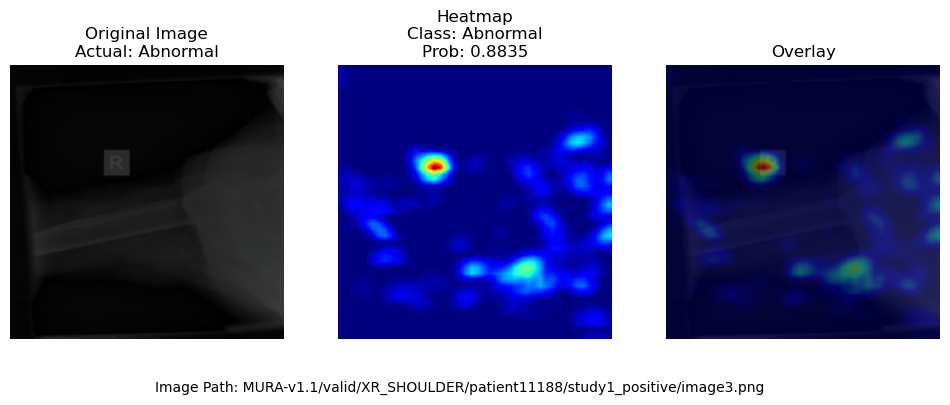

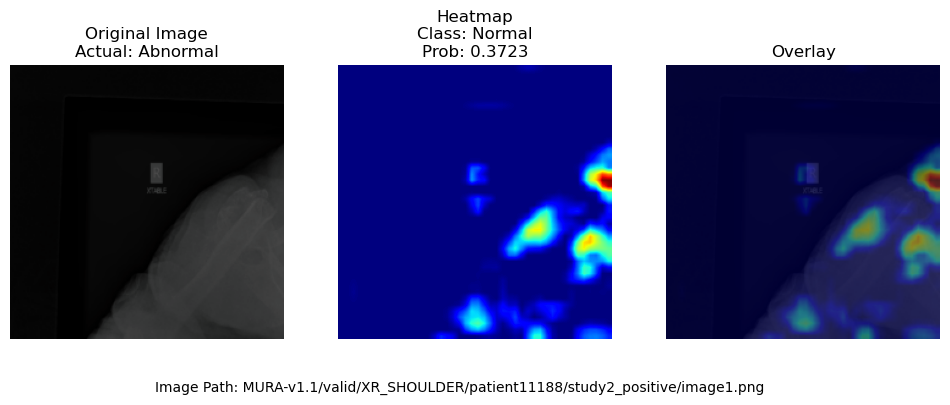

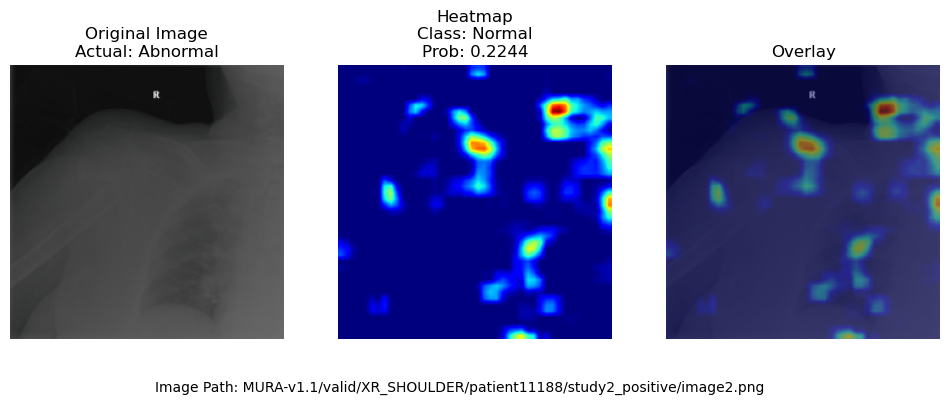

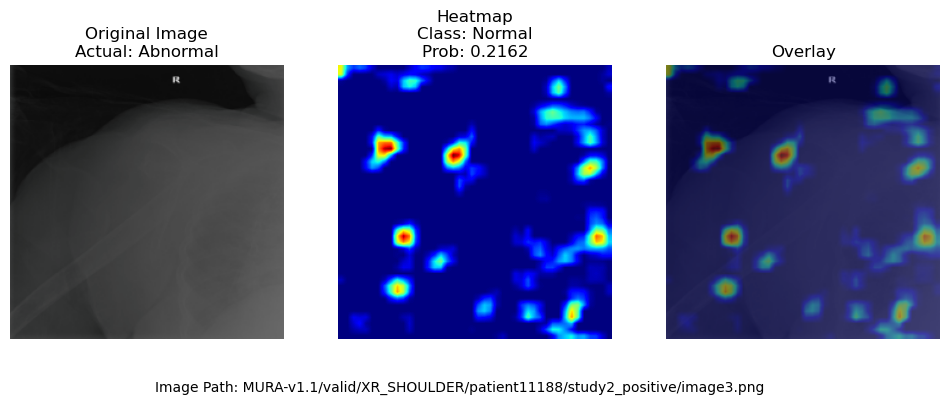

In [52]:
#Specific Person
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    person_id="patient11188",
    device=device
)
